In [1]:
from pathlib import Path
import json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    auc
)
from functools import wraps
from typing import Iterable
from collections import defaultdict

seed = 1234
n_bs = 20
rng = np.random.default_rng(seed)

def bootstrap_metric(metric: callable, rng: np.random.Generator, n_bootstraps: int = 20) -> callable:
    """Bootstrap a metric calculation.

    Args:
        y_true (np.ndarray): True binary labels.
        y_pred_or_probas (np.ndarray): Predicted binary labels or probabilities.
        metric (callable): Metric function to be bootstrapped. Should take y_true and y_pred as arguments.
        threshold (float, optional): Threshold to convert probabilities to binary labels. If None, y_pred_or_probas is assumed to be binary labels. Defaults to None.
        n_bootstraps (int, optional): Number of bootstrap samples. Defaults to 20.

    Returns:
        callable: A function that computes the bootstrapped metric and its 95% confidence interval.
    """
    @wraps(metric)
    def wrapper(y_true: Iterable[int], y_pred_or_probas: Iterable[float | int], threshold: float | None = None, n_bootstraps: int = n_bootstraps, rng: np.random.Generator = rng, *args, **kwargs) -> tuple[float, tuple[float, float]]:
        boot_metrics = []
        n = len(y_true)
        for _ in range(n_bootstraps):
            indices = rng.integers(0, n, n)
            if threshold is not None:
                y_pred_sample = (y_pred_or_probas[indices] >= threshold).astype(int)
            else:
                y_pred_sample = y_pred_or_probas[indices]
            y_true_sample = y_true[indices]
            boot_metric = metric(y_true_sample, y_pred_sample, *args, **kwargs)
            boot_metrics.append(boot_metric)
        boot_metrics = np.array(boot_metrics)
        mean_metric = np.mean(boot_metrics)
        lower_ci = np.percentile(boot_metrics, 2.5)
        upper_ci = np.percentile(boot_metrics, 97.5)
        return mean_metric, (lower_ci, upper_ci)
    return wrapper


def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

discrete_metrics = {
    'f1': bootstrap_metric(f1_score, rng, n_bootstraps=n_bs),
    'binary_precision': bootstrap_metric(precision_score, rng, n_bootstraps=n_bs),
    'binary_recall': bootstrap_metric(recall_score, rng, n_bootstraps=n_bs),
    'accuracy': bootstrap_metric(accuracy_score, rng, n_bootstraps=n_bs),
}

continuous_metrics = {
    'roc_auc': bootstrap_metric(roc_auc_score, rng, n_bootstraps=n_bs),
}

def get_nm_indices(df: pd.DataFrame, neg_multiple: int, seed: int = seed) -> np.ndarray:
    _rng = np.random.default_rng(seed)
    neg_idxs = df[df['y'] == 0].index
    n_to_rm = len(neg_idxs) - (len(df[df['y'] == 1]) * neg_multiple)
 
    if n_to_rm <= 0:
        return np.array(df.index)
    n_to_keep = len(neg_idxs) - n_to_rm
    keep_idxs = _rng.choice(neg_idxs, size=n_to_keep, replace=False)
    all_idxs = np.concatenate((df[df['y'] == 1].index.to_numpy(), keep_idxs))
    return all_idxs

Wrangle top model run ids

In [2]:
filter_split = "params.'data/split_idx' = '-1'"

non_clip = mlflow.search_runs(
    filter_string=filter_split,
)
non_clip.head()

run_id experiment_id    status  \
0  000fc5f378954a27bf934ccd58241a57             0  FINISHED   
1  bafce811361c4d19afe7919fb4666fb2             0  FINISHED   
2  f1cf506a0c0f48b49bbf491f51db24f7             0  FINISHED   
3  c4fdab61494a4affb7b48b3f18b0a314             0   RUNNING   
4  a91ff6acc5a848f18a179c42f5127a85             0  FINISHED   

                                        artifact_uri  \
0  file:///projects/p30041/spn1560/hiec/results/r...   
1  file:///projects/p30041/spn1560/hiec/results/r...   
2  file:///projects/p30041/spn1560/hiec/results/r...   
3  file:///projects/p30041/spn1560/hiec/results/r...   
4  file:///projects/p30041/spn1560/hiec/results/r...   

                        start_time                         end_time  \
0 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:05:19.408000+00:00   
1 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:09:44.076000+00:00   
2 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:22:51.397000+00:00   
3 2025-12-16 14:20:45.276000+00:00                              NaT   
4 2025-12-16 14:20:07.851000+00:00 2025-12-17 02:08:22.087000+00:00   

   metrics.train_loss  metrics.val/mcc  metrics.val/binary_recall  \
0            0.812017         0.415525                   0.508242   
1            0.782236         0.532169                   0.506185   
2            0.804476         0.201330                   0.556306   
3            1.296585         0.567671                   0.810257   
4            1.281589         0.288241                   0.765705   

   metrics.val/f1  ...  params.warmup_epochs  params.init_lr  params.metrics  \
0        0.478540  ...                  None            None            None   
1        0.567073  ...                  None            None            None   
2        0.357161  ...                  None            None            None   
3        0.602225  ...                  None            None            None   
4        0.409551  ...                  None            None            None   

   params.batch_norm  params.X_d_transform  params.model/radius  \
0               None                  None                 None   
1               None                  None                 None   
2               None                  None                 None   
3               None                  None                 None   
4               None                  None                 None   

  tags.mlflow.source.type              tags.mlflow.source.name  \
0                   LOCAL  /home/spn1560/hiec/scripts/train.py   
1                   LOCAL  /home/spn1560/hiec/scripts/train.py   
2                   LOCAL  /home/spn1560/hiec/scripts/train.py   
3                   LOCAL  /home/spn1560/hiec/scripts/train.py   
4                   LOCAL  /home/spn1560/hiec/scripts/train.py   

    tags.mlflow.runName tags.mlflow.user  
0    sincere-grouse-632          spn1560  
1  adventurous-goat-103          spn1560  
2     colorful-tern-162          spn1560  
3      rumbling-koi-381          spn1560  
4     delicate-bird-607          spn1560  

[5 rows x 55 columns]

In [3]:
id2name = {
    row['run_id']: {'data': row['params.data/split_strategy'], 'model': row['params.model/name']}
    for _, row in non_clip.iterrows()
}

id2name['clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold'] = {'data': 'rcmcs', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_drfp_outer_fold'] = {'data': 'drfp', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_esm_outer_fold'] = {'data': 'esm', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold'] = {'data': 'random_reaction', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme'}
# id2name['clipzyme_egnn/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme_egnn'}

In [4]:
best_thresholds = {}
for id in id2name.keys():
    if not (Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {id2name[id]}, skipping...")
        continue
    
    with open(Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[id] = {int(k): v for k, v in this.items()}


In [5]:
preds = {} # Model outputs
nm_keep_indices = {} # Downsampled indices
chance = {}
cols = ['data', 'model', 'neg_multiple', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
evals = []
for id in best_thresholds.keys():
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output
    keep_indices = {
        nm : get_nm_indices(target_output, neg_multiple=nm, seed=seed)
        for nm in best_thresholds[id].keys()
    }

    nm_keep_indices[id] = keep_indices
    for nm in best_thresholds[id].keys():
        th = best_thresholds[id][nm]
        keep_idx = nm_keep_indices[id][nm]
        _target_output = target_output.loc[keep_idx]
        for metric_name, discrete_metric in discrete_metrics.items():
            mean, (ci_l, ci_u) = discrete_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy(), threshold=th)
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

        for metric_name, continuous_metric in continuous_metrics.items():
            mean, (ci_l, ci_u) = continuous_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy())
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

metrics_table = pd.DataFrame(
    evals, columns=cols
)

for _, row in metrics_table.drop_duplicates(['data', 'neg_multiple']).iterrows():
    _target_output = preds[row['id']].loc[nm_keep_indices[row['id']][row['neg_multiple']]]
    for metric in discrete_metrics.keys():
        mean, (ci_l, ci_u) = discrete_metrics[metric](_target_output['y'].to_numpy(), rng.integers(0, 2, size=len(_target_output)))
        chance[(row['data'], row['neg_multiple'], metric)] = mean

metrics_table.head()

data  model  neg_multiple            metric      mean  ci_lower  \
0  random_reaction  rxnfp             1                f1  0.761377  0.753323   
1  random_reaction  rxnfp             1  binary_precision  0.877554  0.869295   
2  random_reaction  rxnfp             1     binary_recall  0.673639  0.667160   
3  random_reaction  rxnfp             1          accuracy  0.788959  0.784564   
4  random_reaction  rxnfp             1           roc_auc  0.883854  0.879604   

   ci_upper                                id  
0  0.768013  000fc5f378954a27bf934ccd58241a57  
1  0.881928  000fc5f378954a27bf934ccd58241a57  
2  0.679860  000fc5f378954a27bf934ccd58241a57  
3  0.792038  000fc5f378954a27bf934ccd58241a57  
4  0.888669  000fc5f378954a27bf934ccd58241a57

In [23]:
# Filter for neg_multiple == 1
nm1_df = metrics_table[metrics_table['neg_multiple'] == 10].copy()

# Pivot to create columns for each metric
pivoted = nm1_df.pivot_table(
    index=['data', 'model'],
    columns='metric',
    values=['mean']
)

# Flatten column names to create mean_metric, ci_lower_metric, ci_upper_metric format
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.reset_index()

pivoted.sort_values(by=['data', 'mean_roc_auc'], ascending=[True, False])

data     model  mean_accuracy  mean_binary_precision  \
0                     drfp  clipzyme       0.954050               0.746865   
1                      esm  clipzyme       0.955276               0.767062   
7          random_reaction    rc_agg       0.964016               0.812101   
3          random_reaction       cgr       0.965790               0.839577   
8          random_reaction    rc_cxn       0.957403               0.803191   
2          random_reaction       bom       0.928867               0.645098   
4          random_reaction  clipzyme       0.871526               0.446304   
5          random_reaction      drfp       0.887785               0.483285   
9          random_reaction     rxnfp       0.882873               0.458414   
6          random_reaction       mfp       0.869245               0.421634   
15  random_reaction_center    rc_agg       0.849850               0.550556   
16  random_reaction_center    rc_cxn       0.866474               0.631803   
11  random_reaction_center       cgr       0.878316               0.636640   
12  random_reaction_center  clipzyme       0.677271               0.301296   
13  random_reaction_center      drfp       0.655787               0.284412   
10  random_reaction_center       bom       0.748652               0.323470   
14  random_reaction_center       mfp       0.657496               0.251666   
17  random_reaction_center     rxnfp       0.683290               0.265286   
24                   rcmcs    rc_cxn       0.939243               0.759899   
23                   rcmcs    rc_agg       0.938613               0.730202   
20                   rcmcs  clipzyme       0.926456               0.638313   
19                   rcmcs       cgr       0.942077               0.767900   
25                   rcmcs     rxnfp       0.915027               0.577916   
18                   rcmcs       bom       0.928500               0.670605   
22                   rcmcs       mfp       0.846906               0.321335   
21                   rcmcs      drfp       0.782436               0.239094   

    mean_binary_recall   mean_f1  mean_roc_auc  
0             0.817193  0.780869      0.975693  
1             0.797159  0.780039      0.975567  
7             0.858729  0.834816      0.985464  
3             0.839487  0.838226      0.982581  
8             0.793304  0.797807      0.974495  
2             0.726802  0.683722      0.942209  
4             0.892217  0.595054      0.920090  
5             0.805070  0.606053      0.908461  
9             0.553569  0.501913      0.883560  
6             0.634250  0.507074      0.852574  
15            0.346399  0.423349      0.835148  
16            0.409853  0.495316      0.818895  
11            0.564647  0.598594      0.808678  
12            0.767252  0.433570      0.763072  
13            0.755814  0.413931      0.733135  
10            0.522487  0.398564      0.729996  
14            0.577368  0.351545      0.680017  
17            0.548487  0.357803      0.665316  
24            0.576173  0.657889      0.939806  
23            0.619453  0.670023      0.938200  
20            0.620900  0.629773      0.929739  
19            0.608150  0.681609      0.915405  
25            0.566492  0.569883      0.915128  
18            0.572863  0.616528      0.908686  
22            0.464446  0.382729      0.755938  
21            0.535777  0.331455      0.726978

# Plotting

In [7]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "rxnfp": "RXNFP",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

get_model_order = lambda x : [list(labels.keys()).index(elt) for elt in x]

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "rxnfp": "silver",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

metrics = {
    'f1': f1_score,
    'binary_precision': precision_score,
    'binary_recall': recall_score,
    'accuracy': accuracy_score
}

metric_names = {
    'f1': "F1",
    'binary_precision': "Precision",
    'binary_recall': "Recall",
    'accuracy': "Accuracy",
    'roc_auc': "ROC-AUC"
}

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
    'drfp': "DRFP",
    'esm': "ESM",
    'random_reaction': "Random reaction",
    'random_reaction_center': "Random reaction center",
    'gsi': "GSI <25%"
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

ROC curves

In [8]:
figsize = (10, 5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

DRFP - Negative multiple 1


DRFP - Negative multiple 3


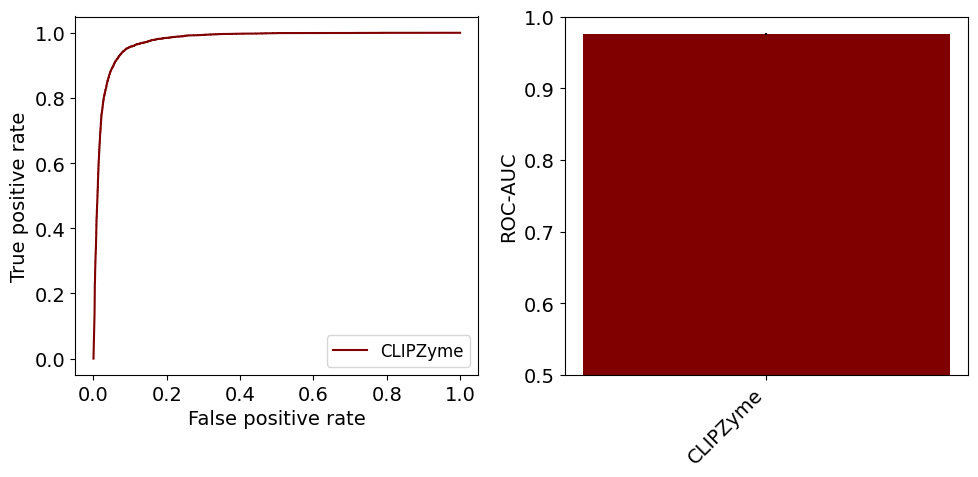

DRFP - Negative multiple 5


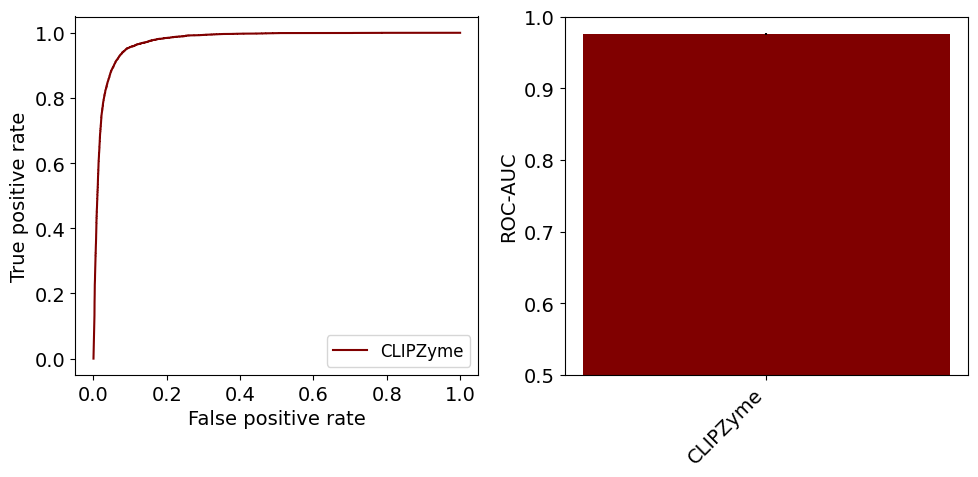

DRFP - Negative multiple 10


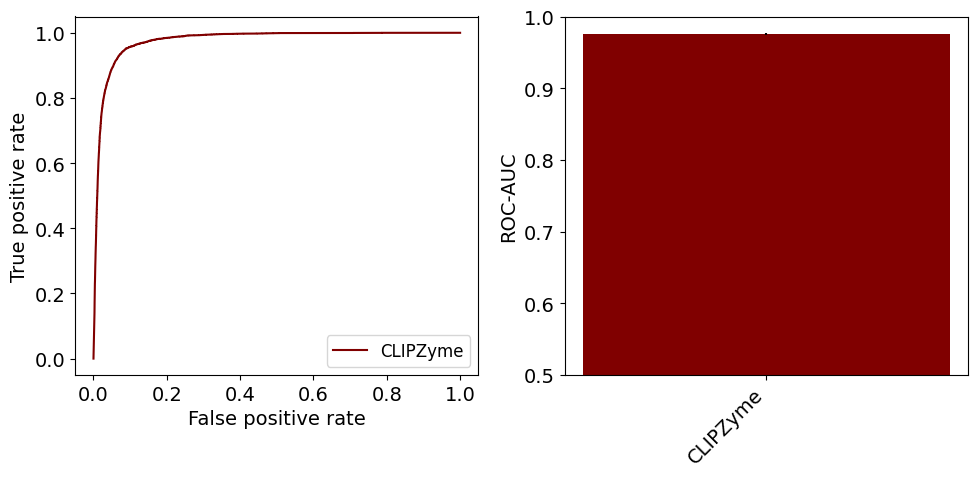

ESM - Negative multiple 1


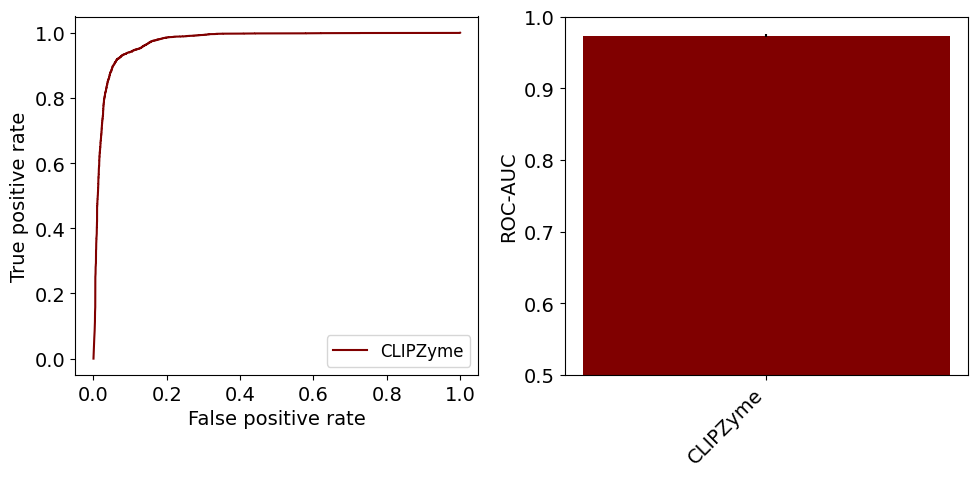

ESM - Negative multiple 3


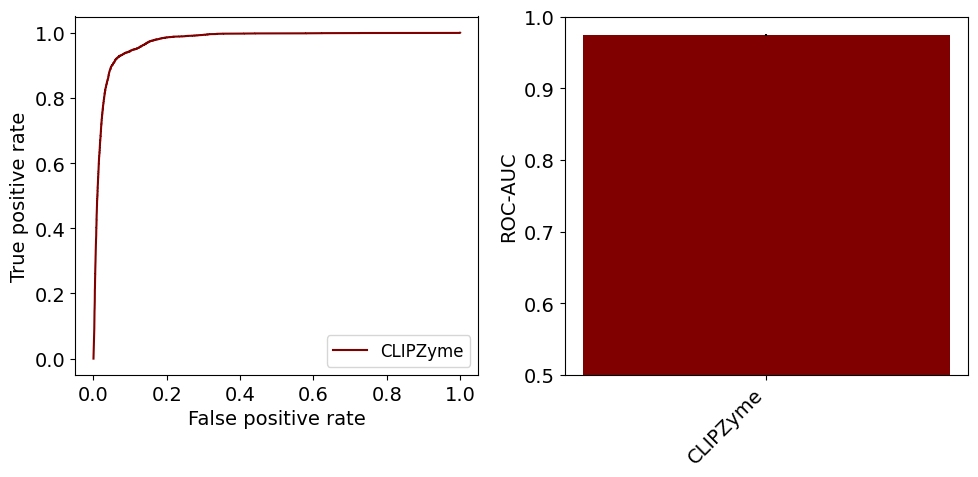

ESM - Negative multiple 5


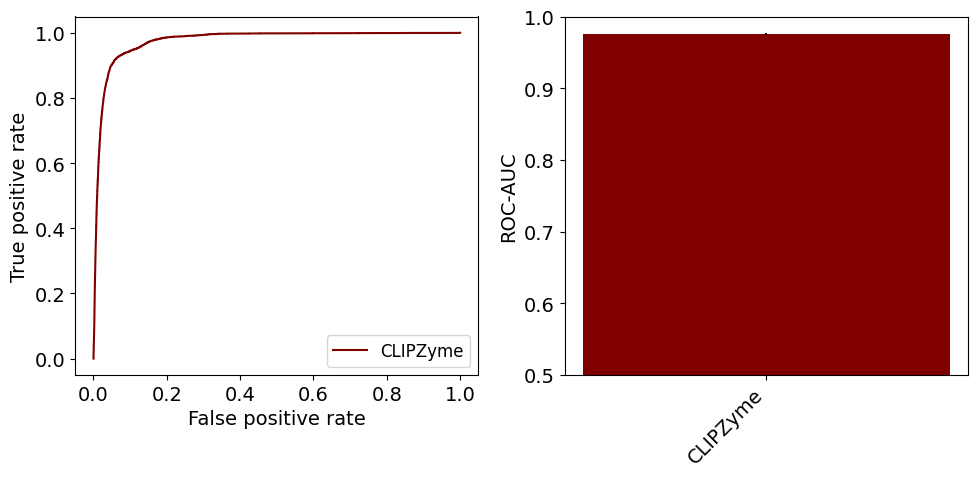

ESM - Negative multiple 10


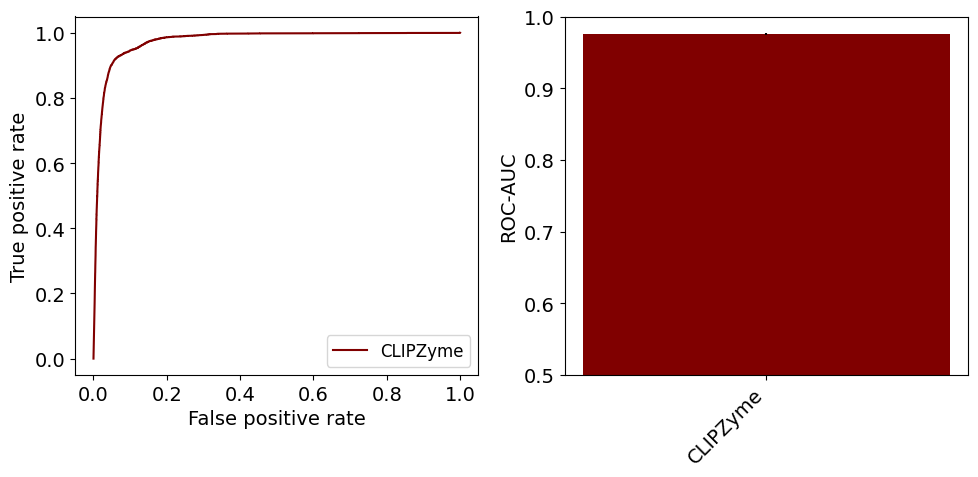

Random reaction - Negative multiple 1


Random reaction - Negative multiple 3


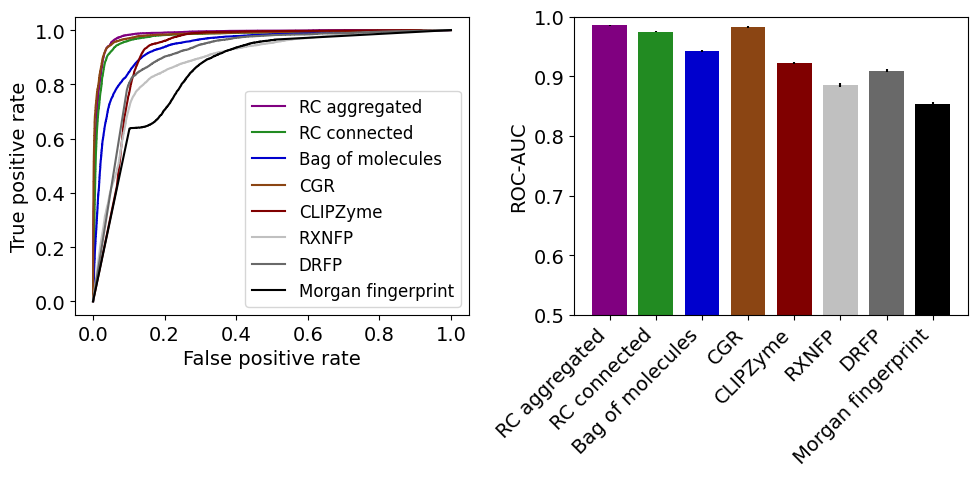

Random reaction - Negative multiple 5


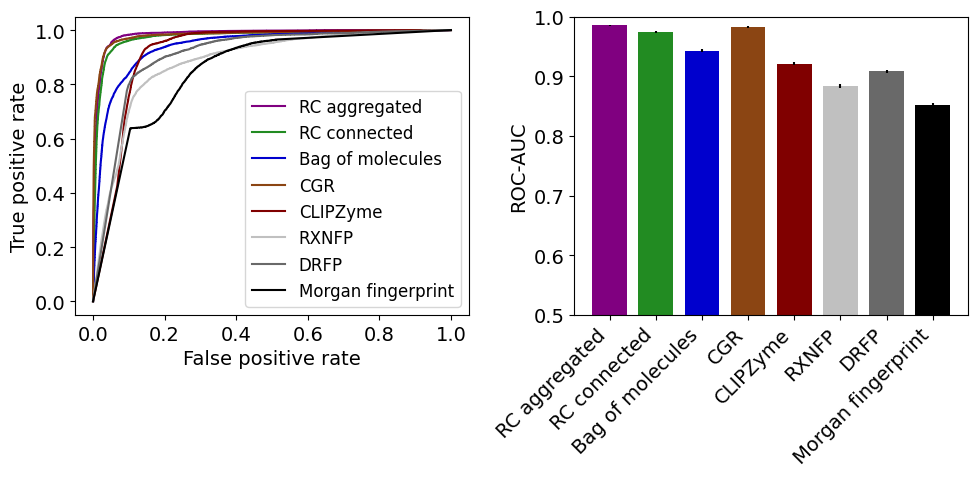

Random reaction - Negative multiple 10


Random reaction center - Negative multiple 1


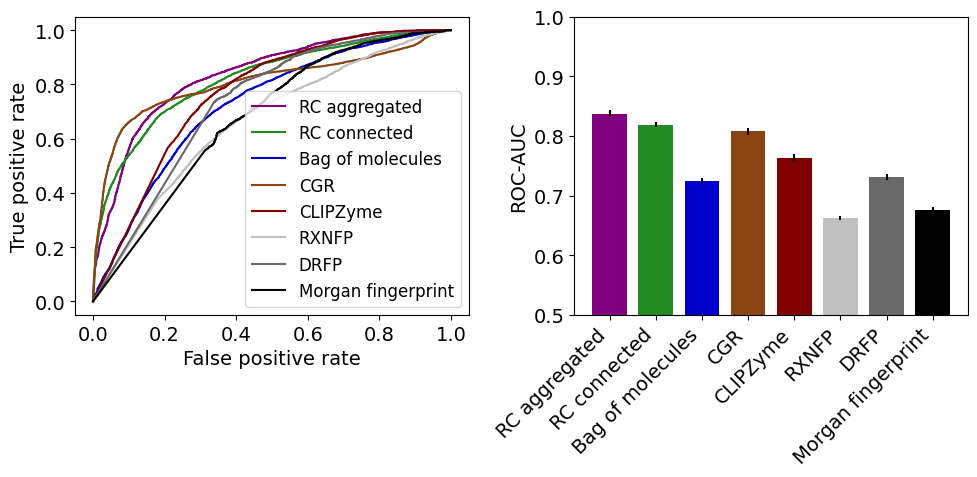

Random reaction center - Negative multiple 3


Random reaction center - Negative multiple 5


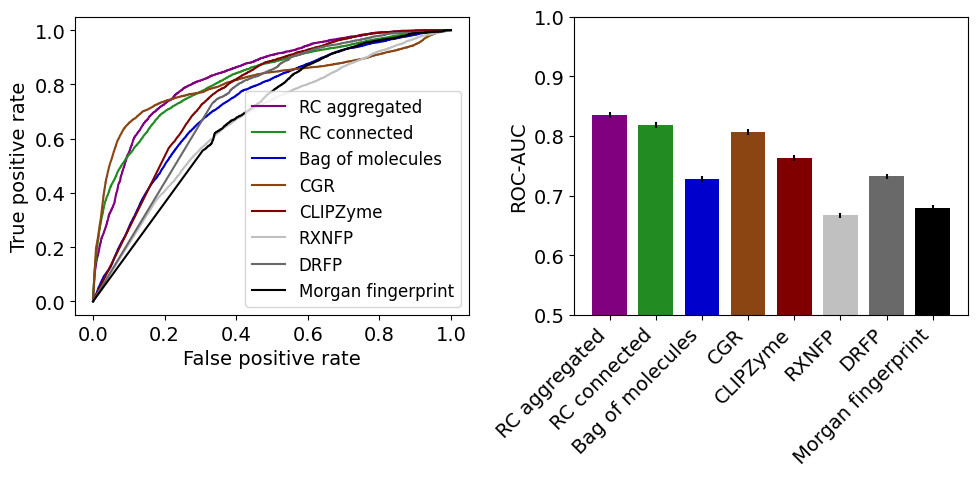

Random reaction center - Negative multiple 10


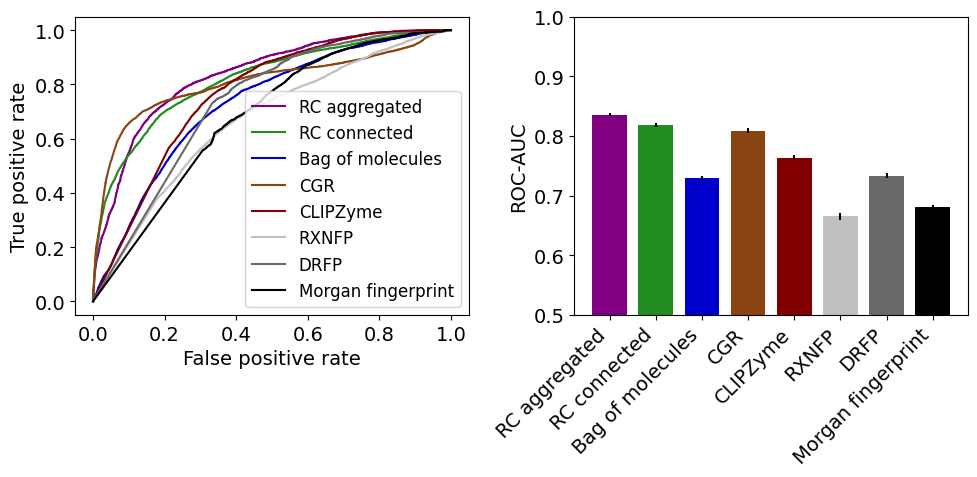

RCMCS - Negative multiple 1


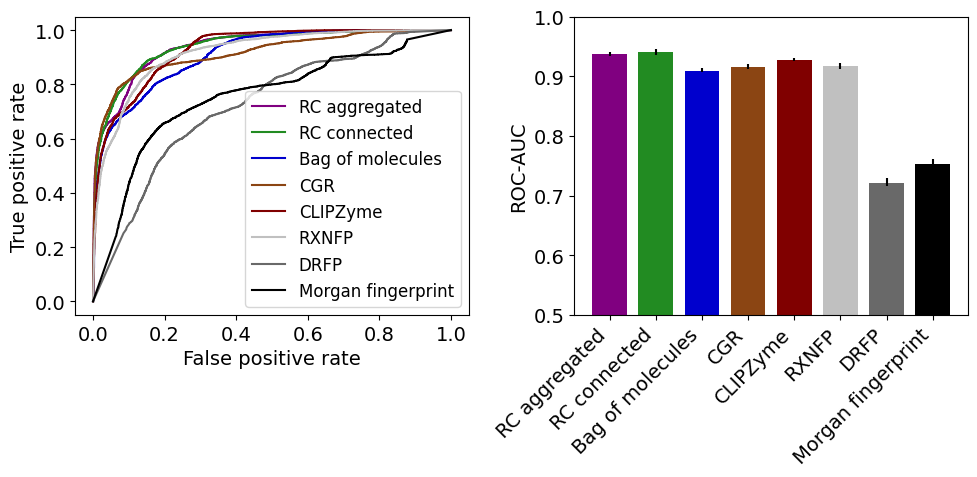

RCMCS - Negative multiple 3


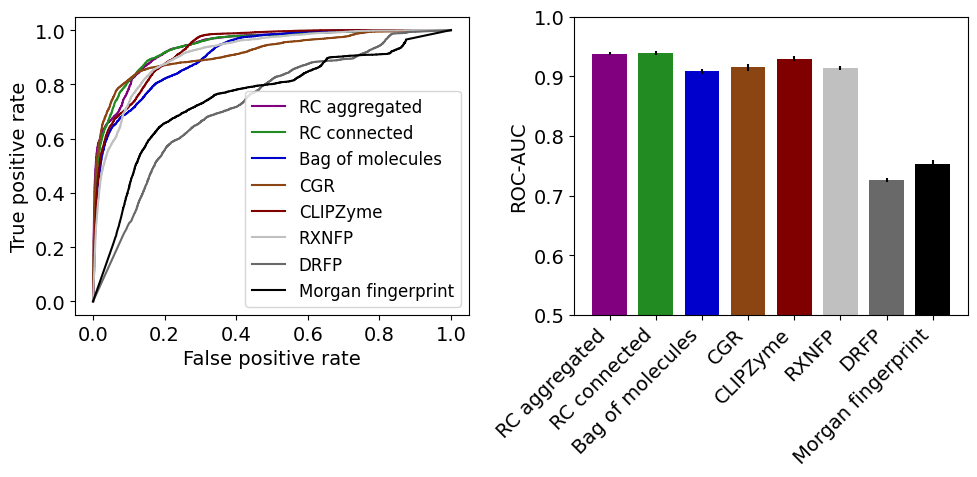

RCMCS - Negative multiple 5


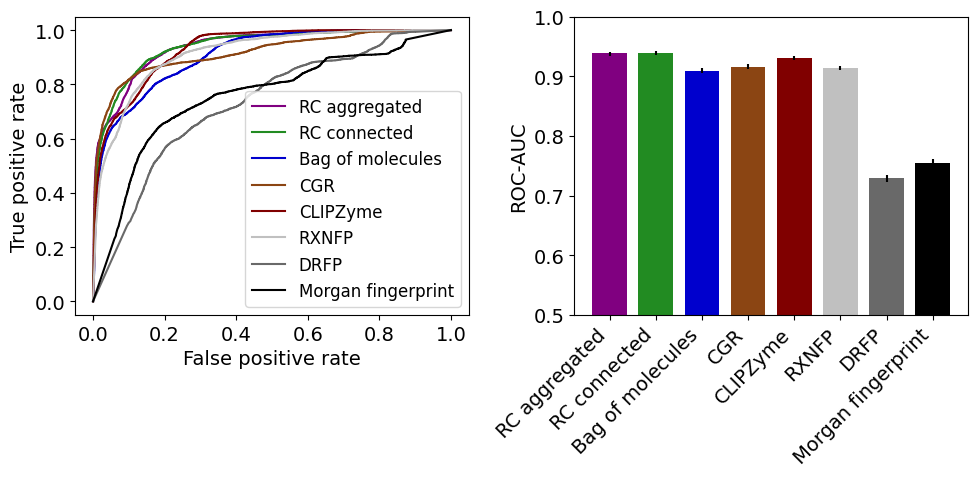

RCMCS - Negative multiple 10


In [9]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    roc_fig, roc_axs = plt.subplots(ncols=2, figsize=figsize)
    for _, row in df.drop_duplicates(['id', 'model']).sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        pred = preds[id].loc[nm_keep_indices[id][nm]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        auroc_u, auroc_cil, auroc_ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == 'roc_auc'),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        roc_axs[0].plot(fpr, tpr, color=colors[model_name], label=labels[model_name])

        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        roc_axs[1].bar(labels[model_name], height=auroc_u, width=width, yerr=ci, color=colors[model_name])
        
        roc_axs[1].set_ylabel("ROC-AUC")
        roc_axs[1].set_ylim(ylim)
        for label in roc_axs[1].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)
    
    roc_axs[0].set_xlabel("False positive rate")
    roc_axs[0].set_ylabel("True positive rate")
    roc_axs[0].legend()
    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.savefig(save_to / "roc" / f"{strat}_nm{nm}_roc.svg")
    plt.show()

Top models inner val metrics with test overlay

In [10]:
# Bar chart constants

figsize = (15, 5)
width = 0.75  # the width of the bars
xtick_rot = 60
xtick_ha = 'right'
scl_chance = 0.9
chance_color = 'orange'

DRFP - Negative multiple 1


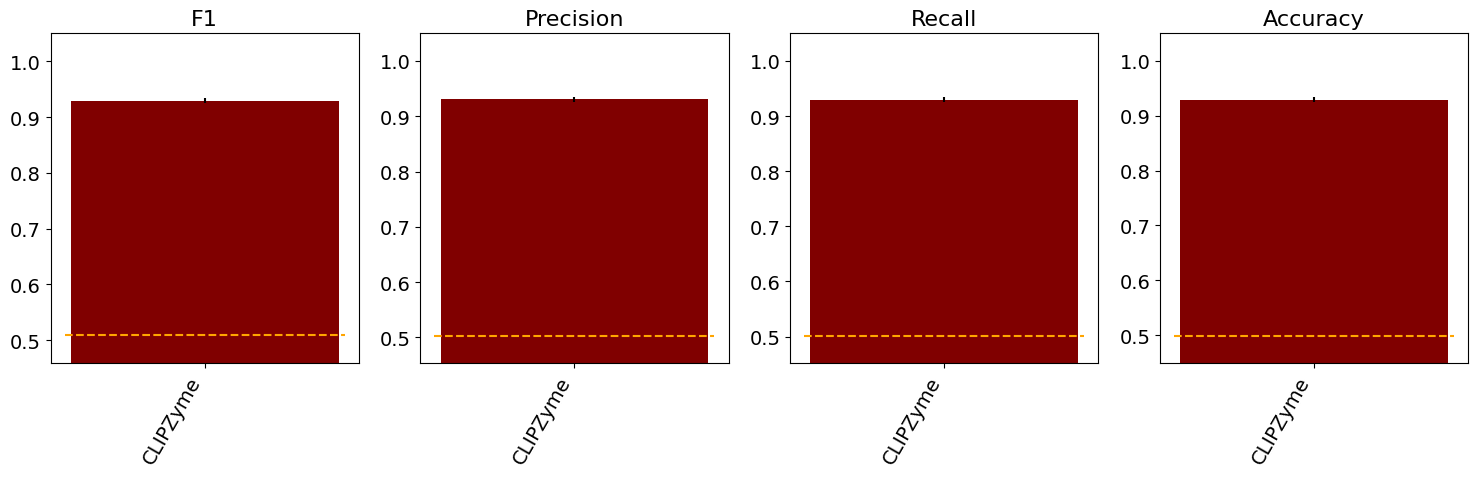

DRFP - Negative multiple 3


DRFP - Negative multiple 5


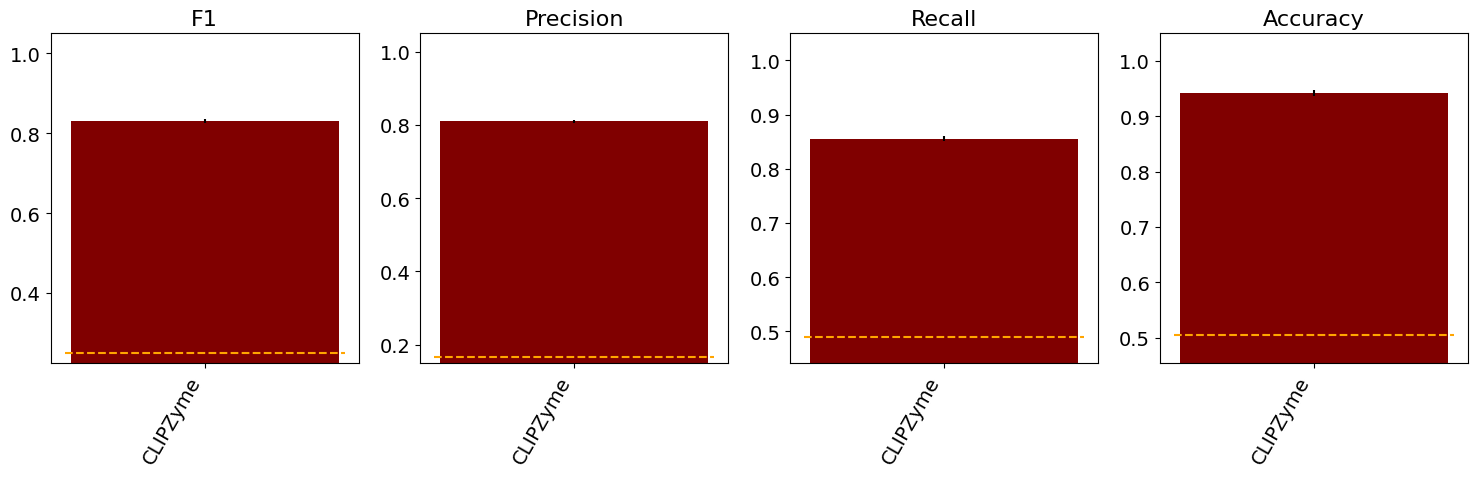

DRFP - Negative multiple 10


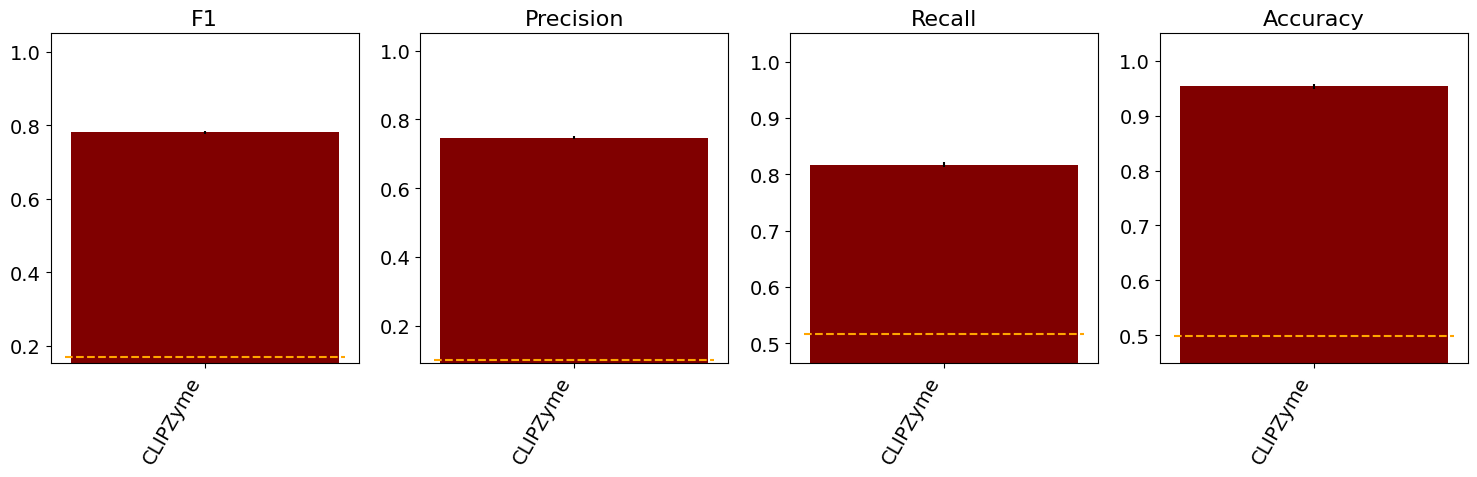

ESM - Negative multiple 1


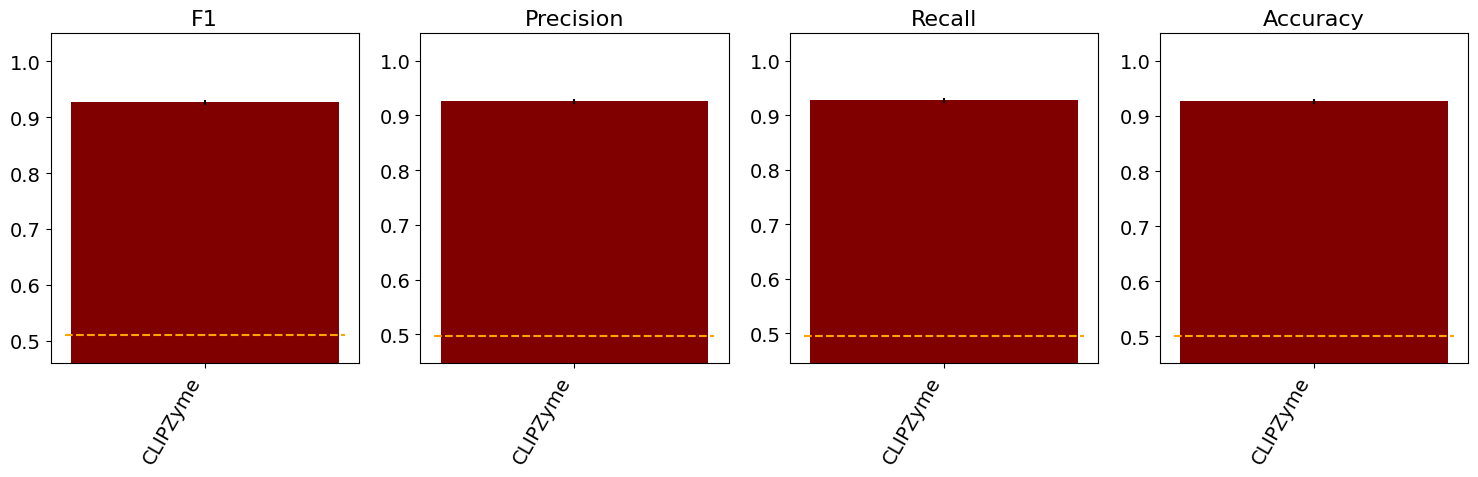

ESM - Negative multiple 3


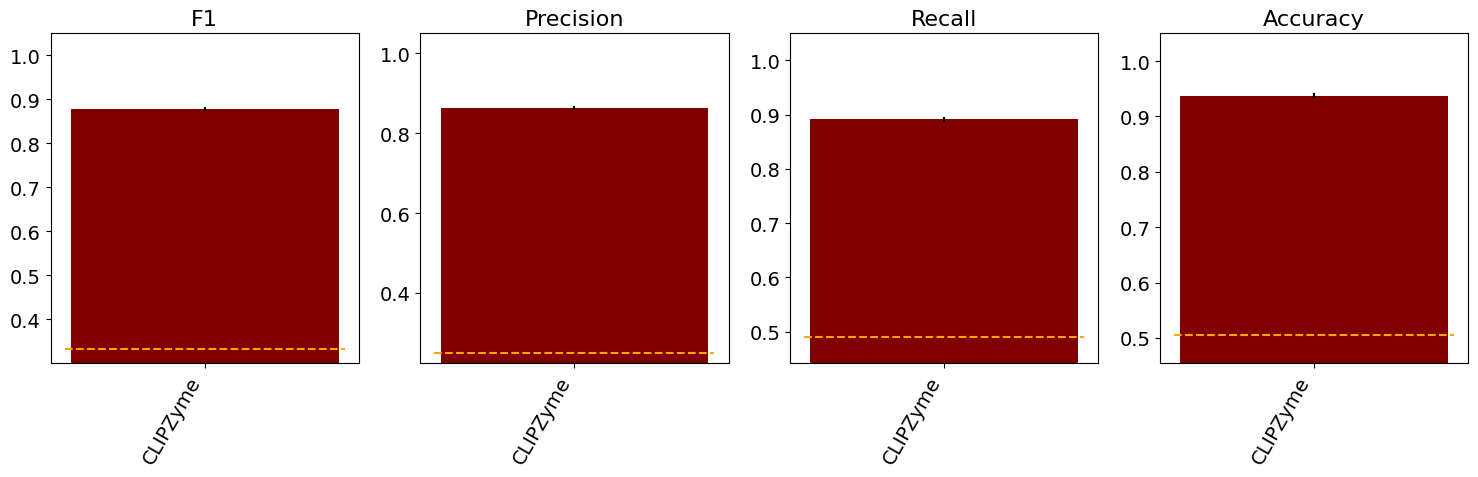

ESM - Negative multiple 5


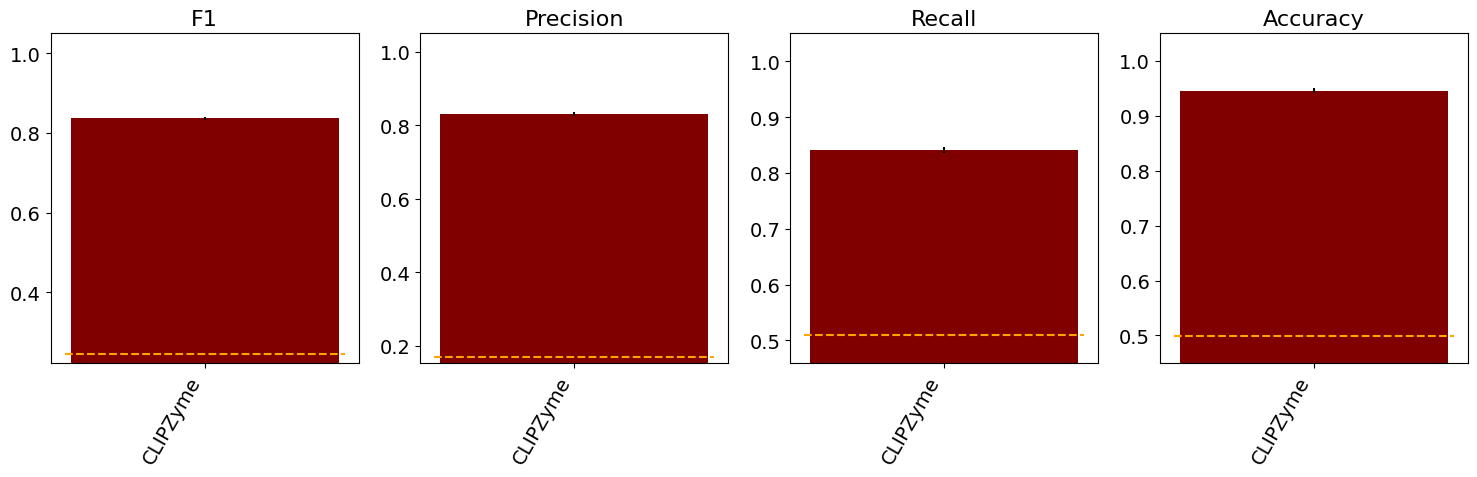

ESM - Negative multiple 10


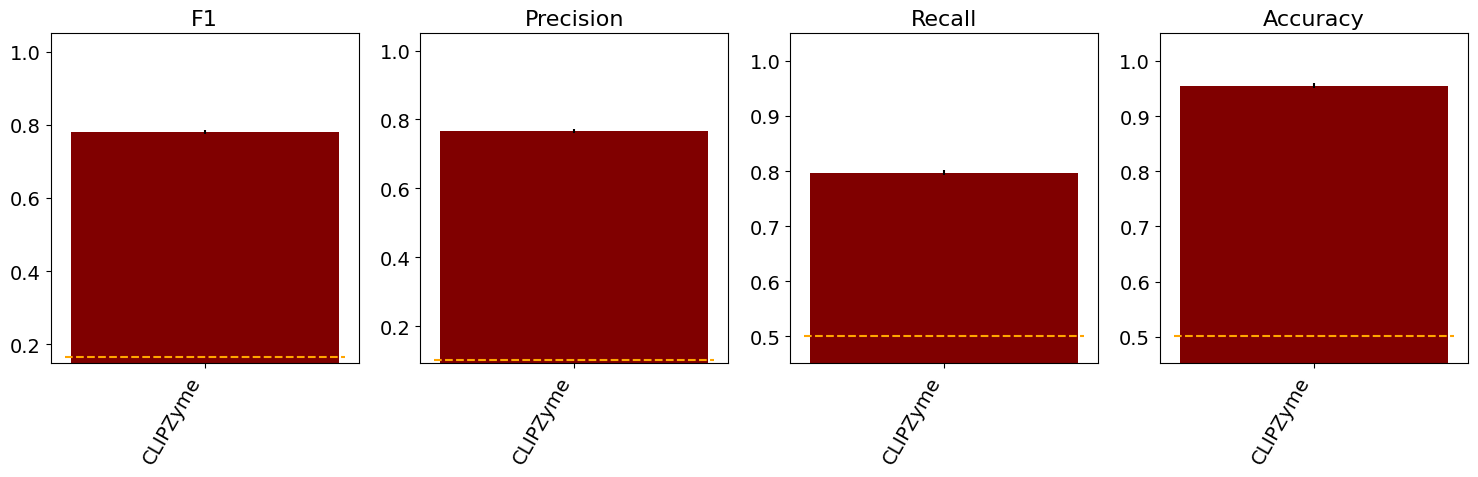

Random reaction - Negative multiple 1


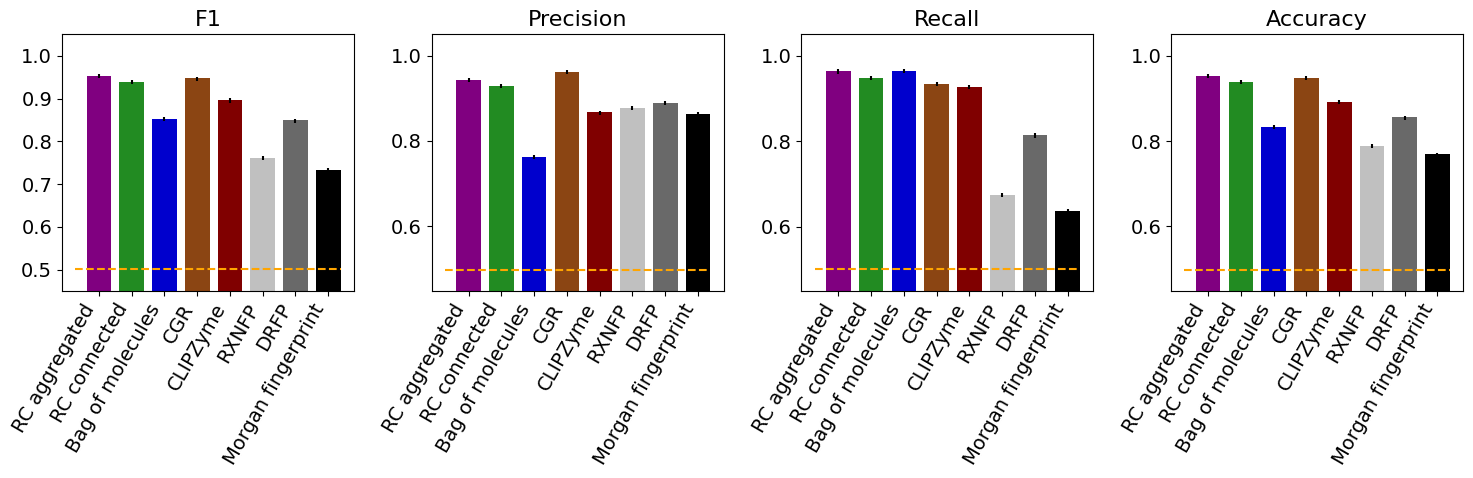

Random reaction - Negative multiple 3


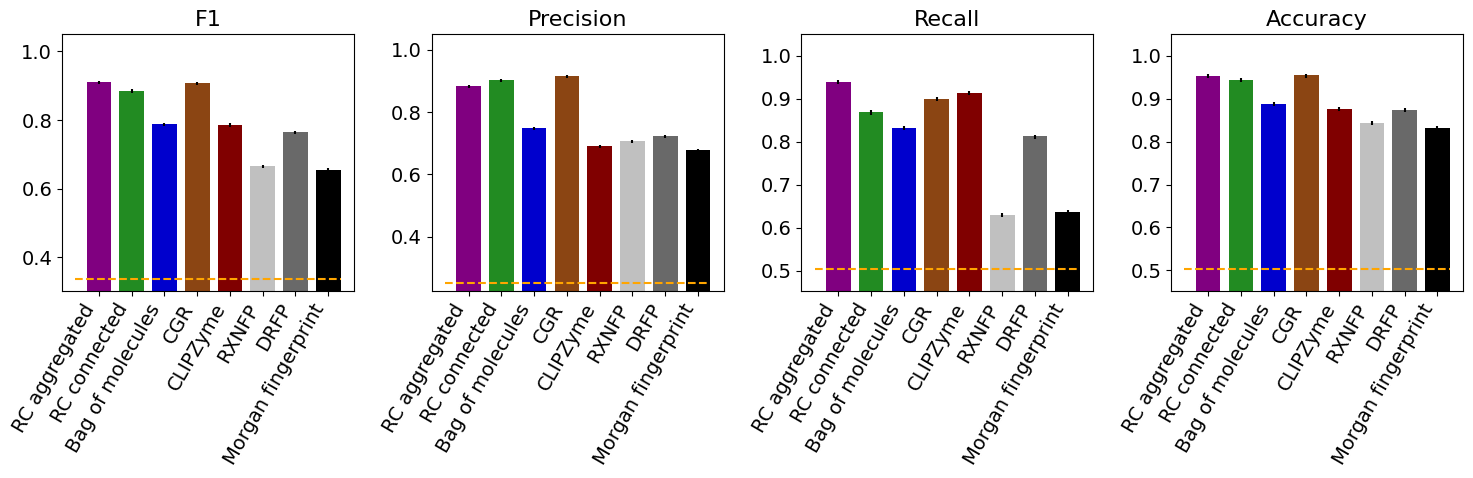

Random reaction - Negative multiple 5


Random reaction - Negative multiple 10


Random reaction center - Negative multiple 1


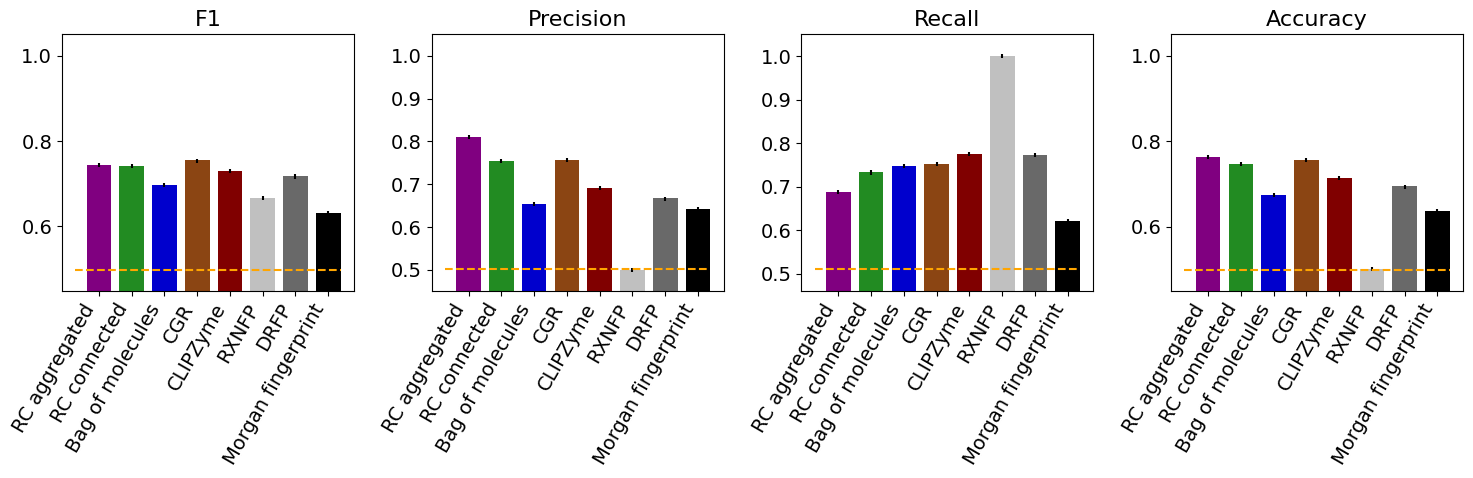

Random reaction center - Negative multiple 3


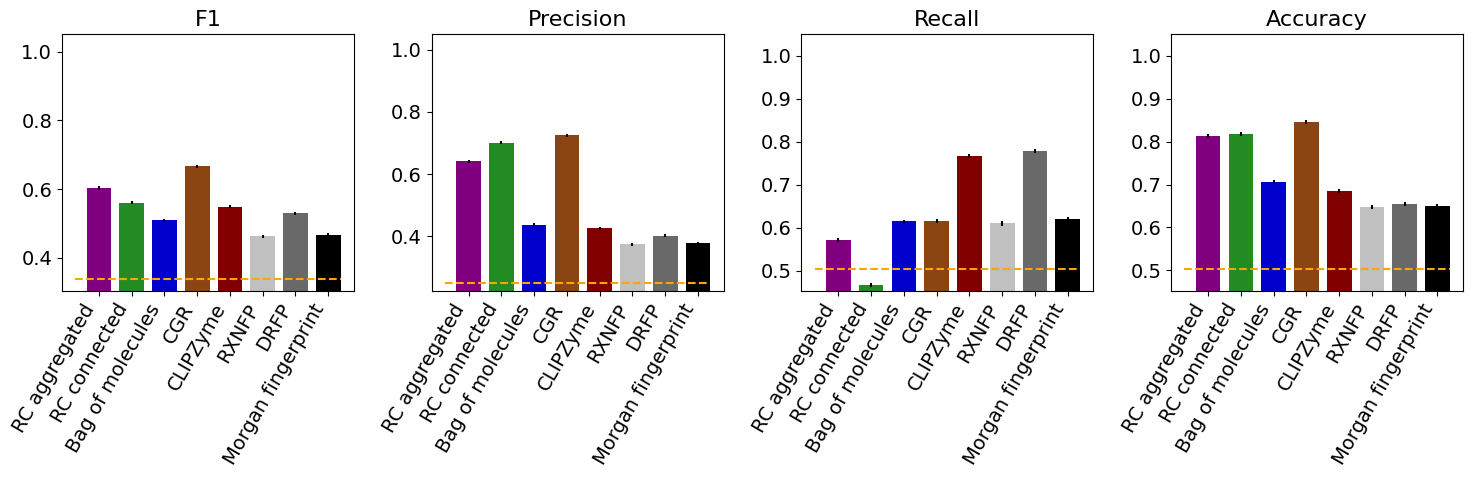

Random reaction center - Negative multiple 5


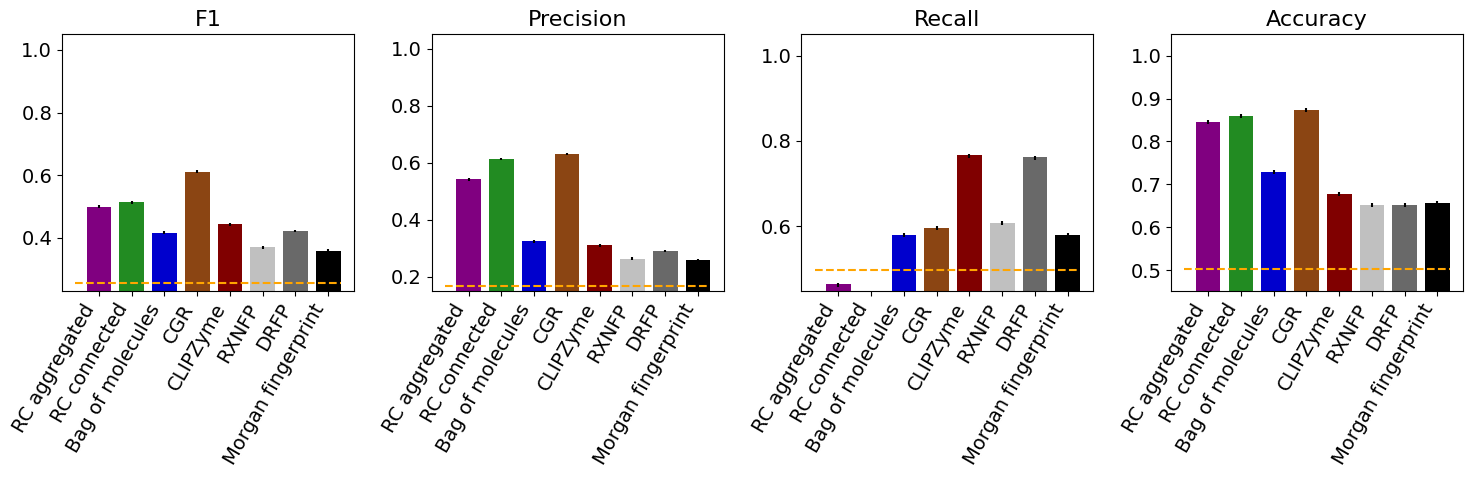

Random reaction center - Negative multiple 10


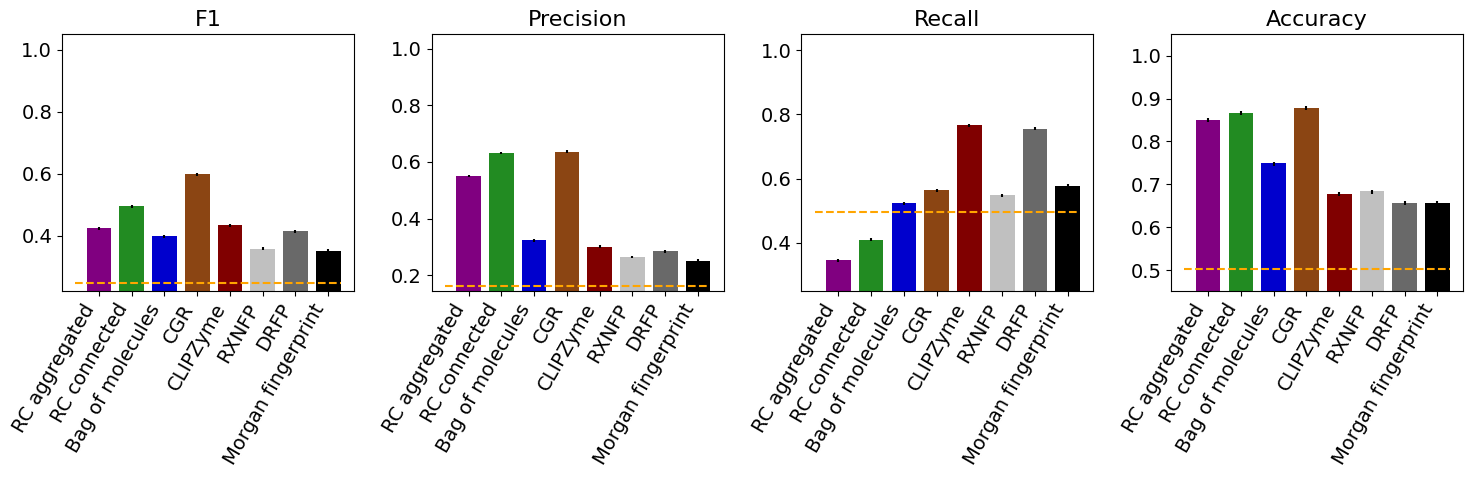

RCMCS - Negative multiple 1


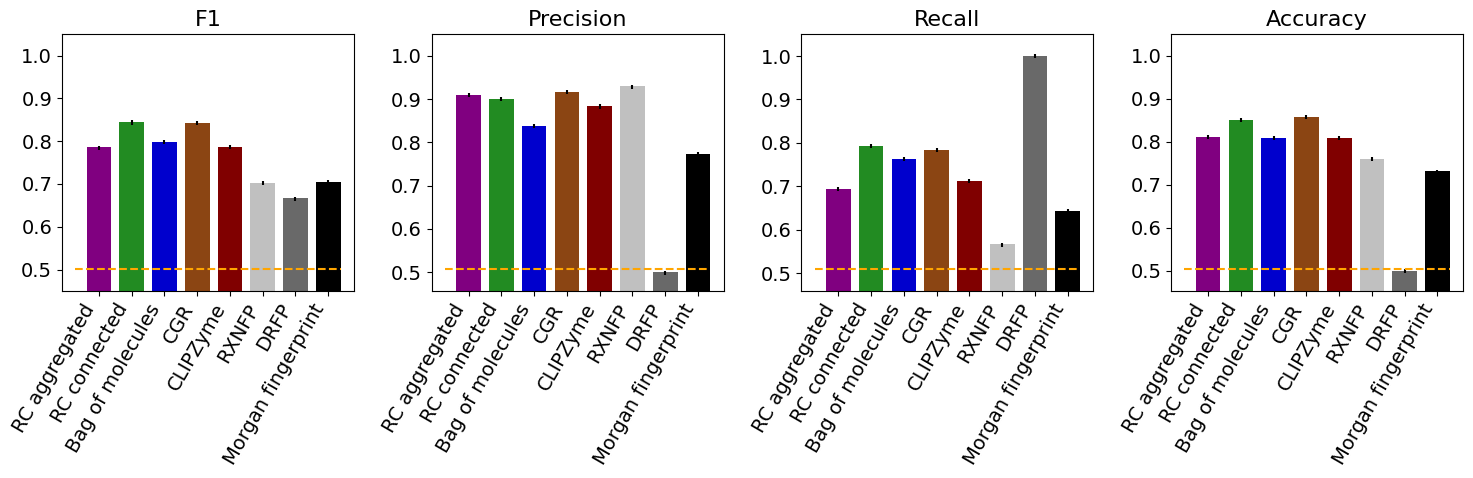

RCMCS - Negative multiple 3


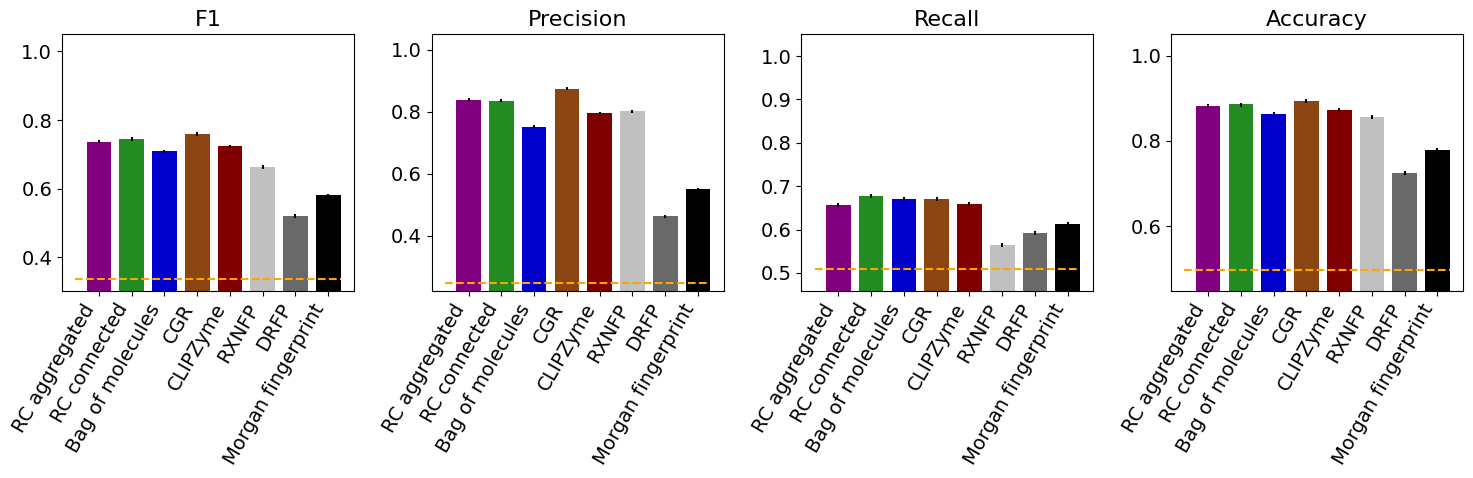

RCMCS - Negative multiple 5


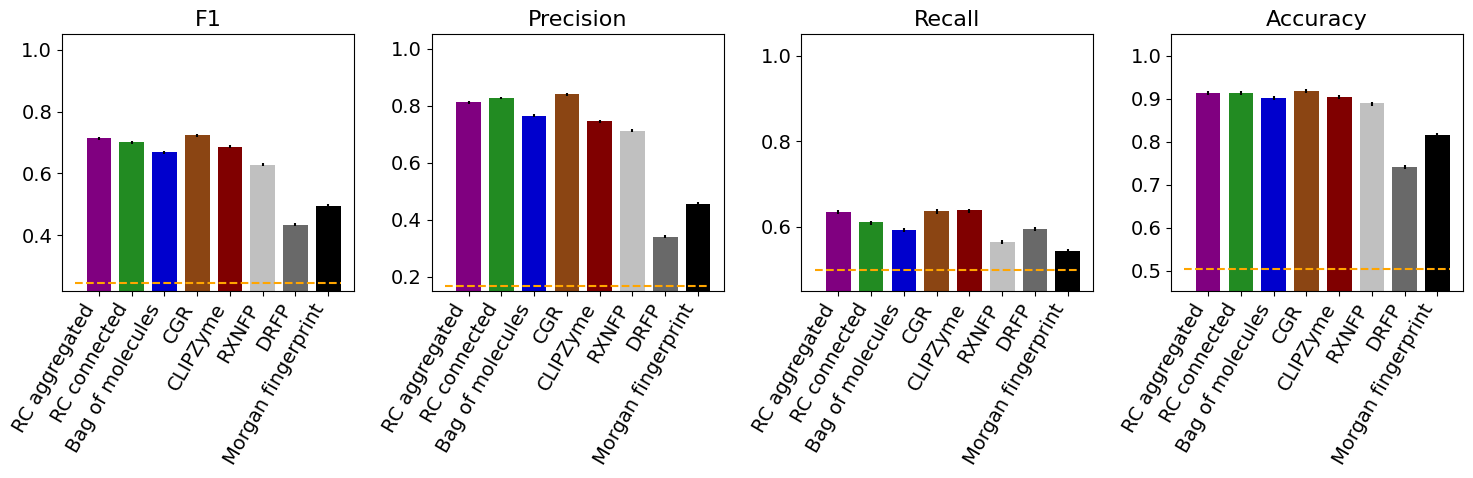

RCMCS - Negative multiple 10


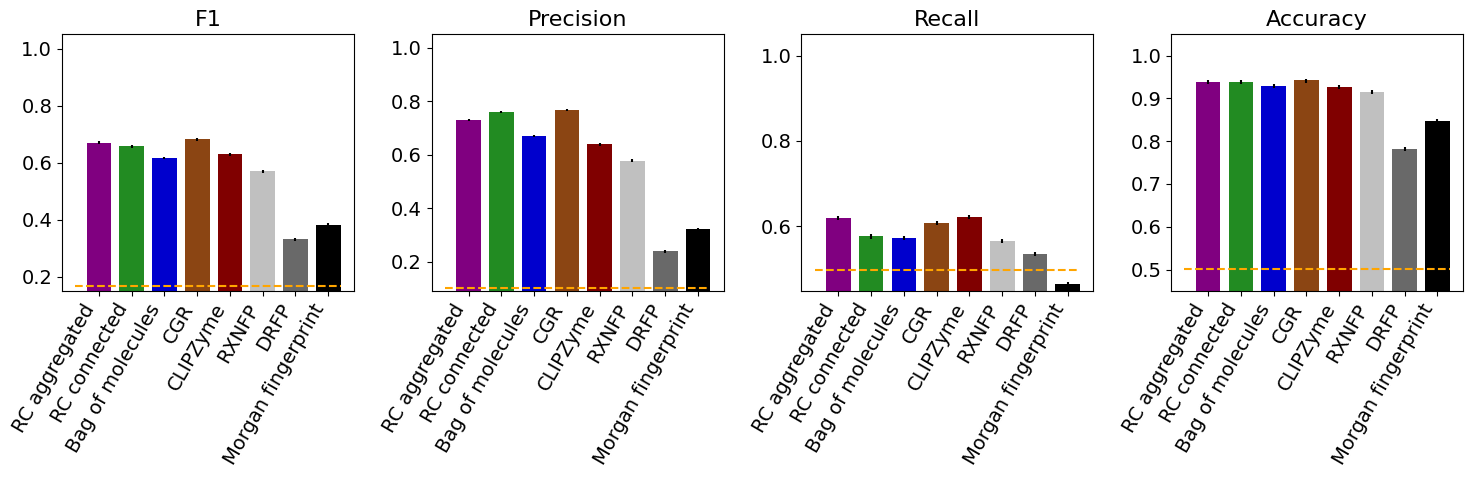

In [11]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=False)
    for _, row in df.sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        metric_k = row['metric']
        if metric_k not in metrics:
            continue
        i = list(metrics.keys()).index(metric_k)
        
        u, cil, ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == metric_k),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        ax[i].bar(labels[model_name], height=u, width=width, yerr=ci, color=colors[model_name])
        

        for label in ax[i].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)

    for i in range(len(ax)):
        metric_k = list(metrics.keys())[i]
        ax[i].set_title(metric_names[metric_k])
        _chance = chance[(strat, nm, metric_k)]

        if similarity_names[strat] == "Random reaction center" and nm == 10 and i == 2:
            ax[i].set_ylim(0.25, 1.05)
        else:
            ax[i].set_ylim(scl_chance * _chance, 1.05)

        # Plot horizontal line at chance from min to max x
        x_min, x_max = [0.95 * elt for elt in ax[i].get_xlim()]
        ax[i].hlines(y=_chance, xmin=x_min, xmax=x_max, color=chance_color, linestyle='--')


    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.savefig(save_to / "binary_classification" / f"{strat}_nm{nm}_bars.svg")
    plt.show()        

Performance broken down by similarity bucket

In [12]:
# Clustered bar chart constants

sim_split_bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ],
    'drfp': [
        (0.6, 1),
        (0.4, 0.6),
        (0.2, 0.4),
        (0.0, 0.2),
    ],
    'esm': [
        (0.98, 1),
        (0.97, 0.98),
    ]

}

In [13]:
split_metrics_table = []
cols = ['data', 'model', 'neg_multiple', 'sim_split', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
for strat, bins in sim_split_bins.items():
    for runid, name in id2name.items():
        if name['data'] != strat:
            continue
        model_name = name['model']
        for nm in nm_keep_indices[runid].keys():
            _target_output = preds[runid].loc[nm_keep_indices[runid][nm]]
            for i, (lb, ub) in enumerate(sim_split_bins[strat]):
                _bin_df = _target_output.loc[(_target_output['max_sim'] >= lb) & (_target_output['max_sim'] < ub)]
                if len(_bin_df) == 0:
                    continue
                for metric_k, metric in discrete_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy(), threshold=best_thresholds[runid][nm])
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
                for metric_k, metric in continuous_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy())
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
split_metrics_table = pd.DataFrame(split_metrics_table, columns=cols)
split_metrics_table.head()

data  model  neg_multiple sim_split            metric      mean  ci_lower  \
0  rcmcs  rxnfp             1  (0.8, 1)                f1  0.879334  0.866130   
1  rcmcs  rxnfp             1  (0.8, 1)  binary_precision  0.945890  0.931349   
2  rcmcs  rxnfp             1  (0.8, 1)     binary_recall  0.819460  0.803617   
3  rcmcs  rxnfp             1  (0.8, 1)          accuracy  0.899354  0.889207   
4  rcmcs  rxnfp             1  (0.8, 1)           roc_auc  0.958153  0.953321   

   ci_upper                                id  
0  0.891142  bafce811361c4d19afe7919fb4666fb2  
1  0.956216  bafce811361c4d19afe7919fb4666fb2  
2  0.832225  bafce811361c4d19afe7919fb4666fb2  
3  0.907475  bafce811361c4d19afe7919fb4666fb2  
4  0.963963  bafce811361c4d19afe7919fb4666fb2

In [14]:
bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.12
space = 1.05
figsize = (15, 4)
metrics_of_i = [
    'f1',
    'roc_auc',
    # 'accuracy'
]

drfp 1


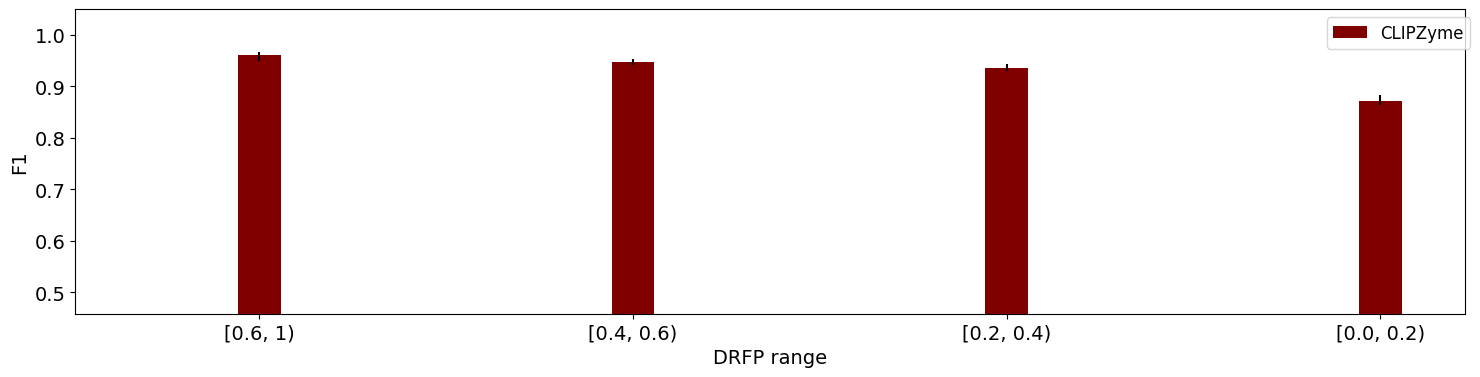

drfp 3


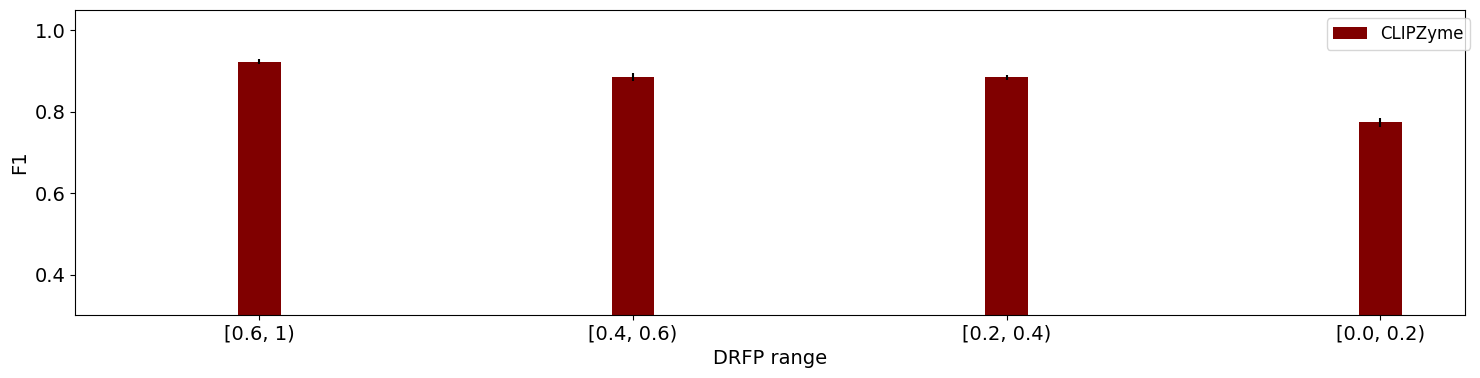

drfp 5


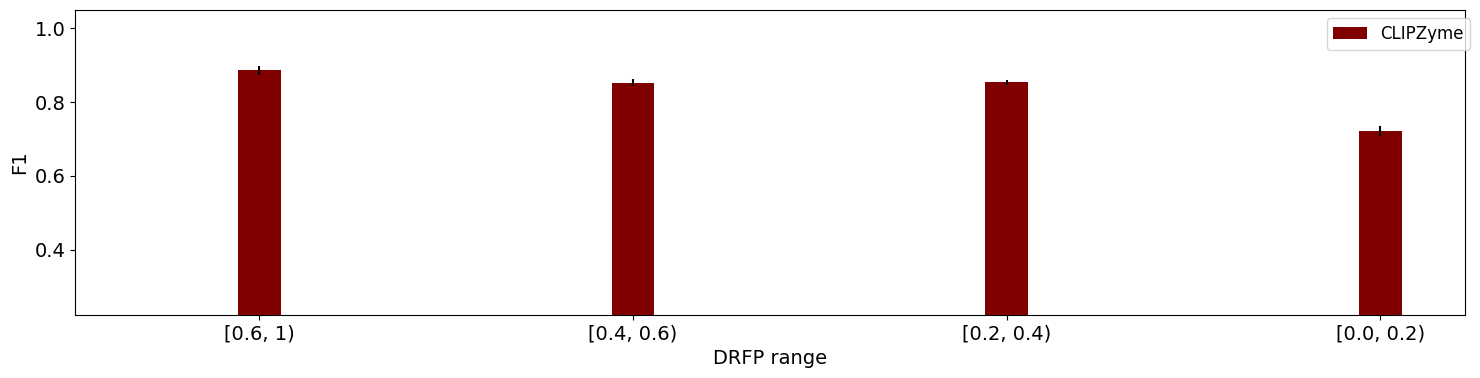

drfp 10


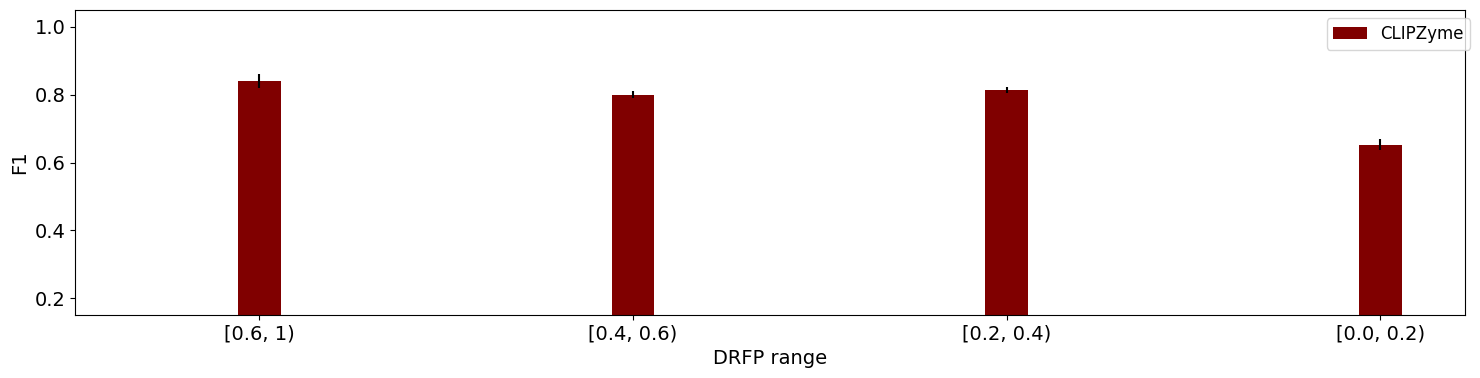

drfp 1


drfp 3


drfp 5


drfp 10


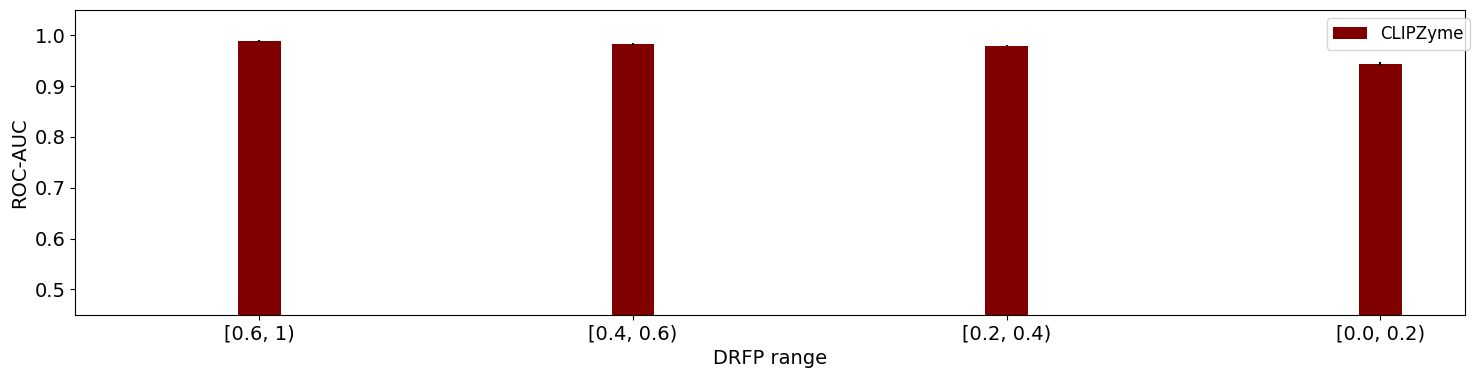

esm 1


esm 3


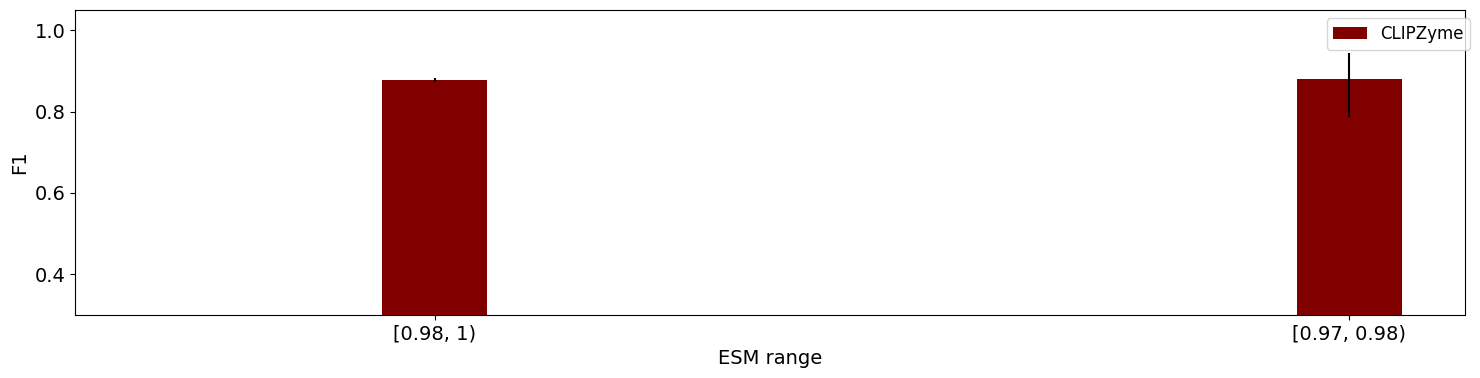

esm 5


esm 10


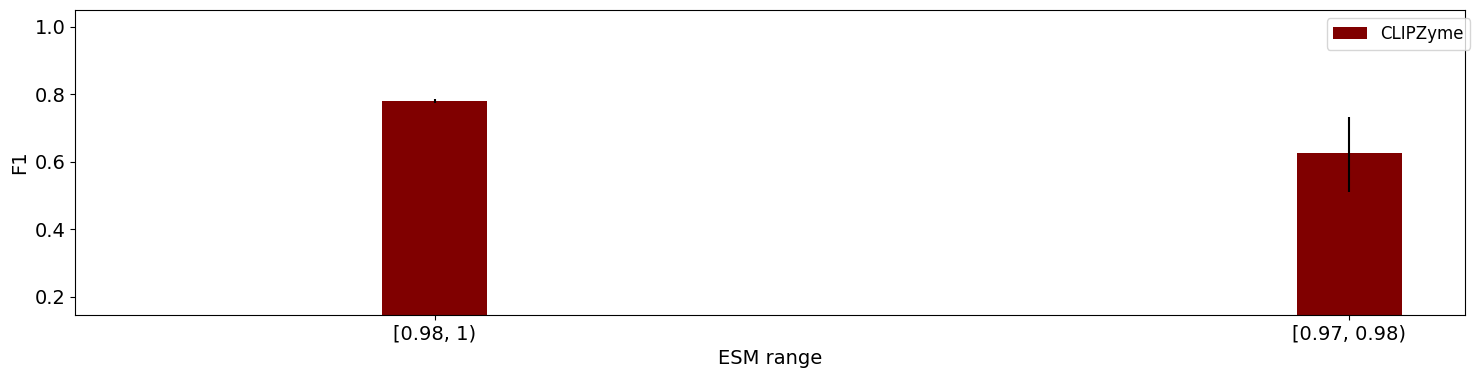

esm 1


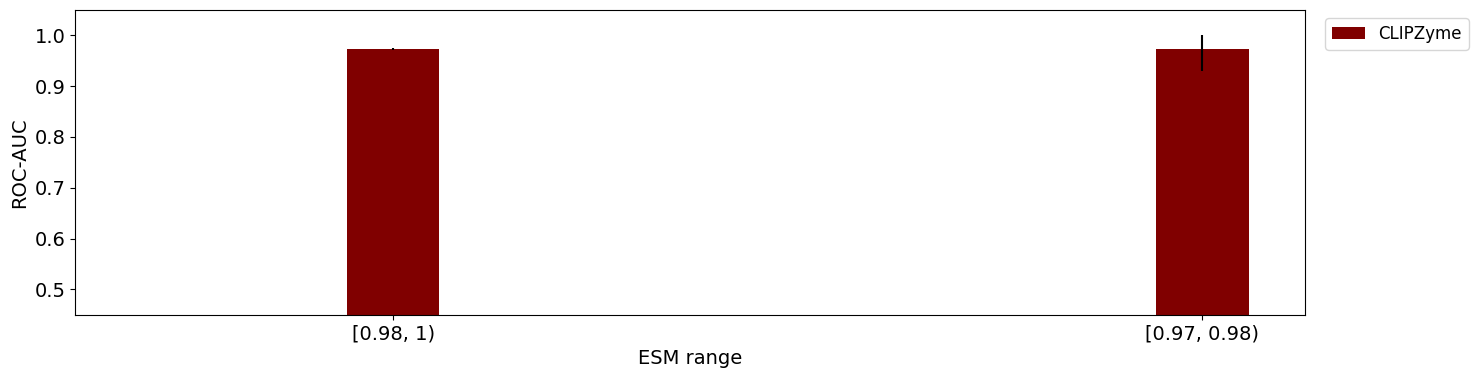

esm 3


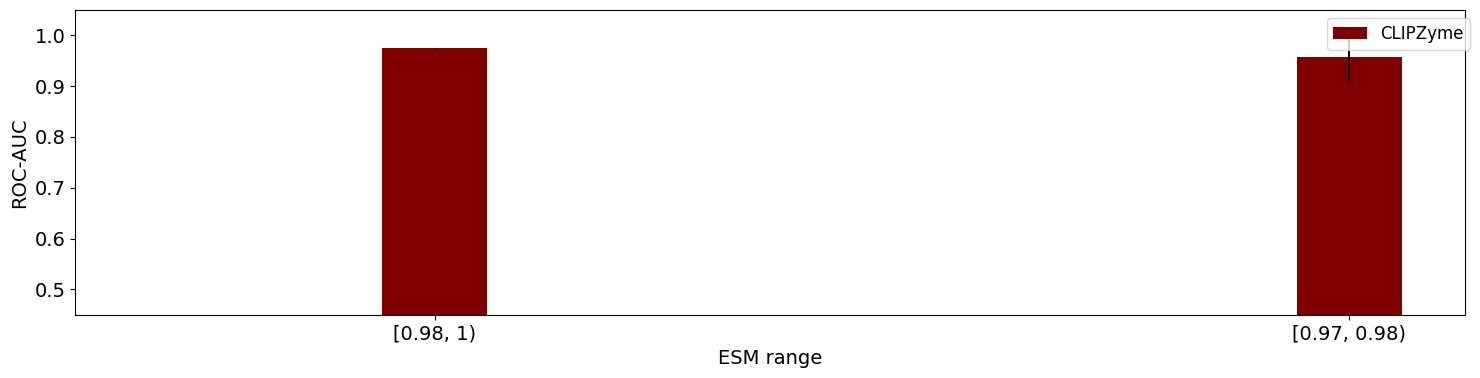

esm 5


esm 10


rcmcs 1


rcmcs 3


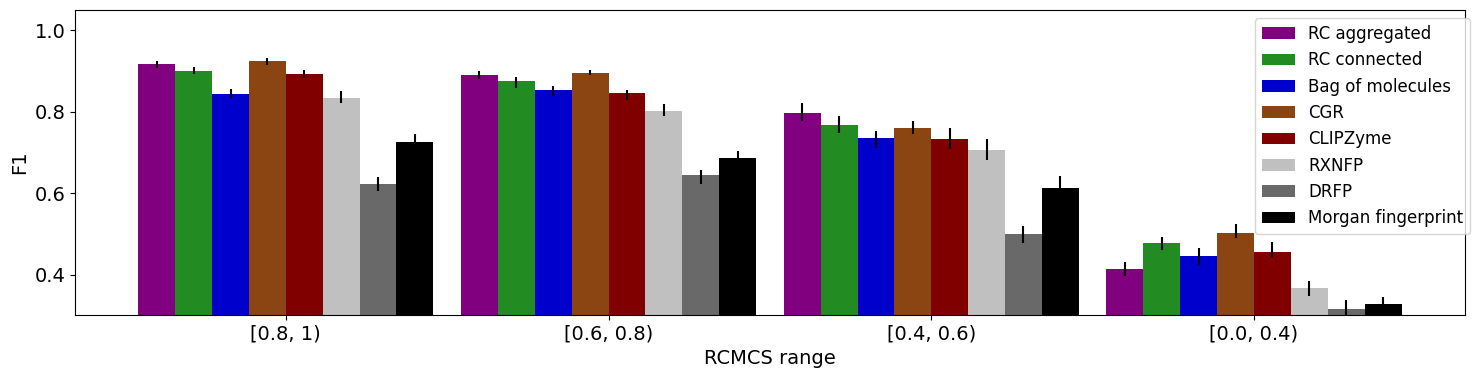

rcmcs 5


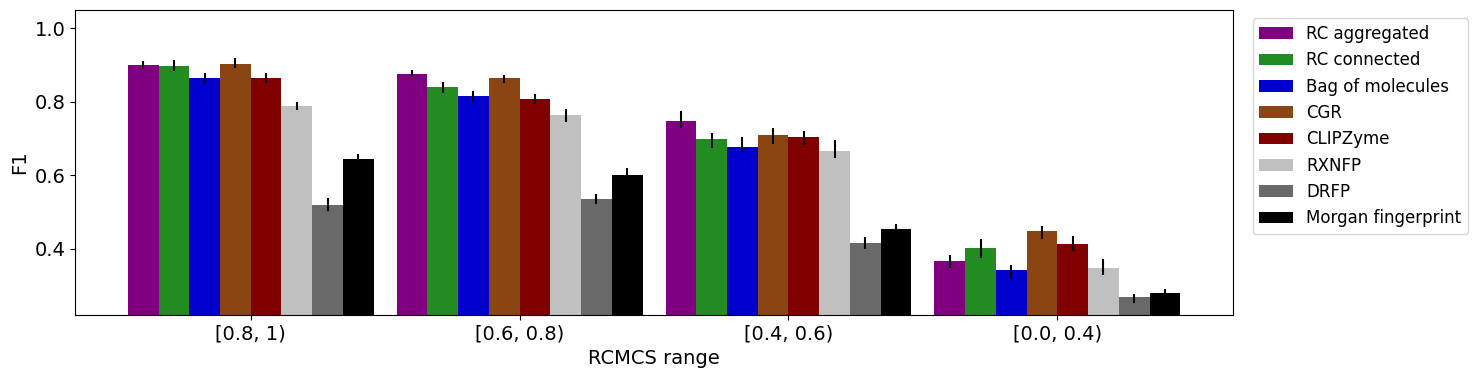

rcmcs 10


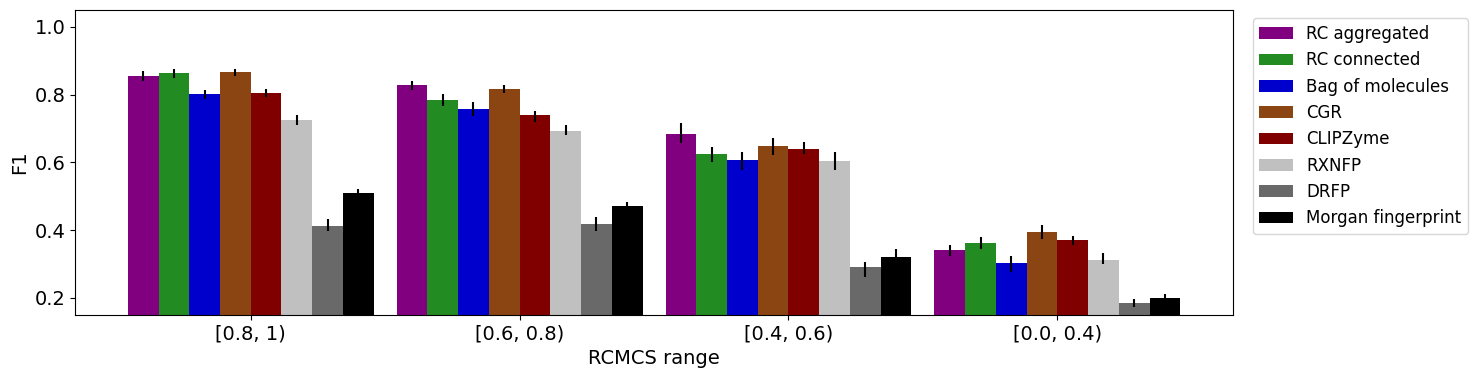

rcmcs 1


rcmcs 3


rcmcs 5


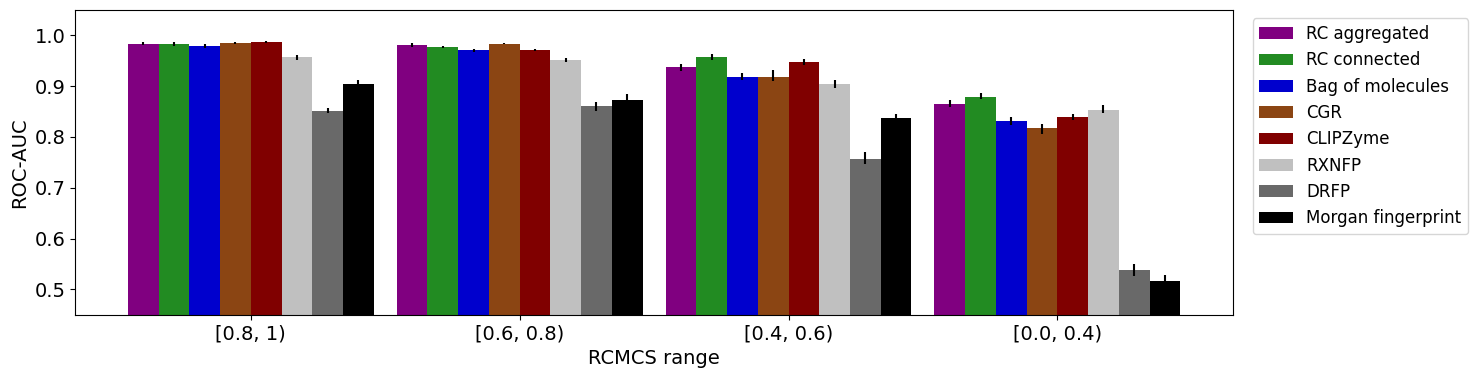

rcmcs 10


In [15]:
for (strat, metric_k, nm), df in split_metrics_table.groupby(['data', 'metric', 'neg_multiple']):
    if metric_k not in metrics_of_i:
        continue
    print(strat, nm)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    for (lb, ub), bunch in df.groupby('sim_split'):
        j = 0
        offset = (len(bunch) / 2) * width
        for _, row in bunch.sort_values(by='model', key=get_model_order).iterrows():
            x = sim_split_bins[strat].index(row['sim_split']) * space
            model_name = row['model']
            val = row['mean']
            ci = np.array([row['mean'] - row['ci_lower'], row['ci_upper'] - row['mean']]).reshape(2, 1)
            ax.bar(x=x - offset + width * j, height=val, yerr=ci, width=width, color=colors[model_name])
            j += 1

    for key in bunch.sort_values(by='model', key=get_model_order)['model']:
        ax.bar(0, 0, color=colors[key], label=labels[key])
    
    # ax.set_ylim(*ylim[strat])
    _chance = chance.get((strat, nm, metric_k), 0.5)
    ax.set_ylim(scl_chance * _chance, 1.05)
    ax.set_xticks(np.arange(len(sim_split_bins[strat])) * space - width / 2)
    ax.set_xticklabels(bins2labels(sim_split_bins[strat]))
    ax.set_ylabel(metric_names[metric_k])
    ax.set_xlabel(f"{similarity_names[strat]} range")
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.savefig(save_to / "by_split" / f"{strat}_nm{nm}_similarity_clustered_{metric_names[metric_k]}.svg")
    plt.show()
            

In [16]:
split_metrics_table.loc[
    (split_metrics_table['data'] == 'rcmcs') &
    (split_metrics_table['neg_multiple'] == 10) &
    (split_metrics_table['metric'] == 'roc_auc') &
    (split_metrics_table['sim_split'] == (0, 0.4))
].sort_values(by='mean', ascending=False)

data     model  neg_multiple   sim_split   metric      mean  ci_lower  \
399  rcmcs    rc_cxn            10  (0.0, 0.4)  roc_auc  0.882443  0.878392   
479  rcmcs    rc_agg            10  (0.0, 0.4)  roc_auc  0.867259  0.860531   
79   rcmcs     rxnfp            10  (0.0, 0.4)  roc_auc  0.852790  0.846616   
639  rcmcs  clipzyme            10  (0.0, 0.4)  roc_auc  0.835271  0.828279   
559  rcmcs       bom            10  (0.0, 0.4)  roc_auc  0.829763  0.822383   
239  rcmcs       cgr            10  (0.0, 0.4)  roc_auc  0.818339  0.806796   
159  rcmcs      drfp            10  (0.0, 0.4)  roc_auc  0.539869  0.531959   
319  rcmcs       mfp            10  (0.0, 0.4)  roc_auc  0.515920  0.505087   

     ci_upper                                                id  
399  0.885945                  af29e2f62cf34bf2824dc8c72e086da5  
479  0.871301                  da9ed201898a451a8a822cf1a30ec30b  
79   0.859406                  bafce811361c4d19afe7919fb4666fb2  
639  0.841479  clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold  
559  0.834415                  d1a3cc3f1d36488e8222efda0d595914  
239  0.827501                  e627a08cec3c47e18b4fd9f1ade6b9fe  
159  0.548647                  36a93d8131bd460599ef98740f8d322d  
319  0.531754                  04cc886dade64a68a84b151ddd92cef2

In [17]:
id2name

{'000fc5f378954a27bf934ccd58241a57': {'data': 'random_reaction',
  'model': 'rxnfp'},
 'bafce811361c4d19afe7919fb4666fb2': {'data': 'rcmcs', 'model': 'rxnfp'},
 'f1cf506a0c0f48b49bbf491f51db24f7': {'data': 'random_reaction_center',
  'model': 'rxnfp'},
 'c4fdab61494a4affb7b48b3f18b0a314': {'data': 'random_reaction',
  'model': 'drfp'},
 'a91ff6acc5a848f18a179c42f5127a85': {'data': 'random_reaction_center',
  'model': 'drfp'},
 '36a93d8131bd460599ef98740f8d322d': {'data': 'rcmcs', 'model': 'drfp'},
 '120f090f4b3e471a965979401b3271ae': {'data': 'random_reaction',
  'model': 'cgr'},
 '34cda1e3f64a4b18a98894ed0e86be86': {'data': 'random_reaction_center',
  'model': 'cgr'},
 'e627a08cec3c47e18b4fd9f1ade6b9fe': {'data': 'rcmcs', 'model': 'cgr'},
 '7e836b6654ac4b9aba81fe692b059c5d': {'data': 'random_reaction',
  'model': 'mfp'},
 'ec2310e5872f47de8b9c81d1edce26b9': {'data': 'random_reaction_center',
  'model': 'mfp'},
 '04cc886dade64a68a84b151ddd92cef2': {'data': 'rcmcs', 'model': 'mfp'},
 '5

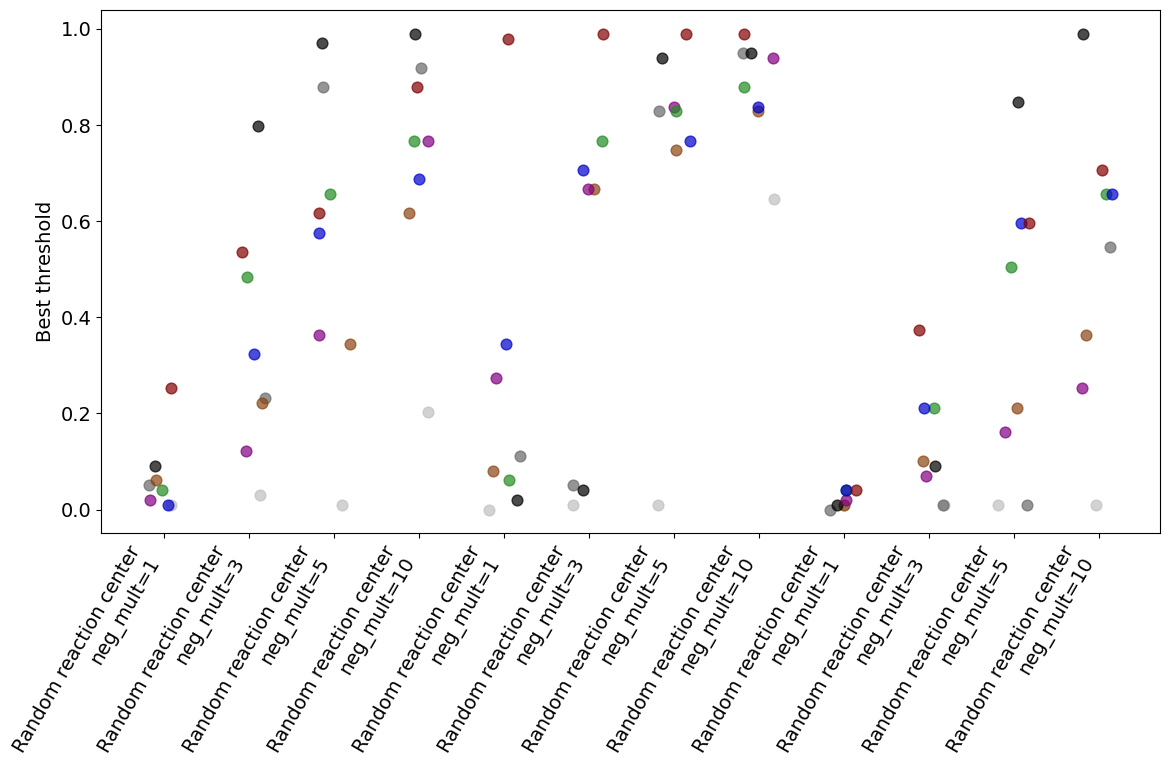

In [18]:
# Collect thresholds for each (data, neg_multiple, model) combo
blacklist = ['drfp', 'esm']
scatter_data = []
for id, name in id2name.items():
    for nm, th in best_thresholds.get(id, {}).items():
        if name['data'] in blacklist:
            continue
        scatter_data.append((name['data'], nm, name['model'], th))

# Prepare unique (data, neg_multiple) combos and mapping
combos = sorted(set((d, nm) for d, nm, _, _ in scatter_data))
combo2x = {combo: i for i, combo in enumerate(combos)}

plt.figure(figsize=(max(8, len(combos)), 8))
for d, nm, m, th in scatter_data:
    condition_name = similarity_names.get(d, d)
    x = combo2x[(d, nm)] + np.random.uniform(-0.2, 0.2)
    plt.scatter(x, th, alpha=0.7, s=60, label=m, color=colors.get(m, 'gray'))

plt.xticks(
    range(len(combos)),
    [f"{condition_name}\nneg_mult={nm}" for d, nm in combos],
    rotation=60,
    ha='right'
)
plt.ylabel("Best threshold")
plt.tight_layout()
plt.savefig("/home/stef/hiec/artifacts/figures/methods/best_thresholds_scatter.svg")
plt.show()


In [19]:
# Add best_thresholds column to metrics_table by looking up (runid, neg_multiple) in best_thresholds dict
metrics_table['best_thresholds'] = metrics_table.apply(
    lambda r: best_thresholds.get(r['id'], {}).get(int(r['neg_multiple']), np.nan),
    axis=1
)

metrics_table.head()

data  model  neg_multiple            metric      mean  ci_lower  \
0  random_reaction  rxnfp             1                f1  0.761377  0.753323   
1  random_reaction  rxnfp             1  binary_precision  0.877554  0.869295   
2  random_reaction  rxnfp             1     binary_recall  0.673639  0.667160   
3  random_reaction  rxnfp             1          accuracy  0.788959  0.784564   
4  random_reaction  rxnfp             1           roc_auc  0.883854  0.879604   

   ci_upper                                id  best_thresholds  
0  0.768013  000fc5f378954a27bf934ccd58241a57         0.010101  
1  0.881928  000fc5f378954a27bf934ccd58241a57         0.010101  
2  0.679860  000fc5f378954a27bf934ccd58241a57         0.010101  
3  0.792038  000fc5f378954a27bf934ccd58241a57         0.010101  
4  0.888669  000fc5f378954a27bf934ccd58241a57         0.010101

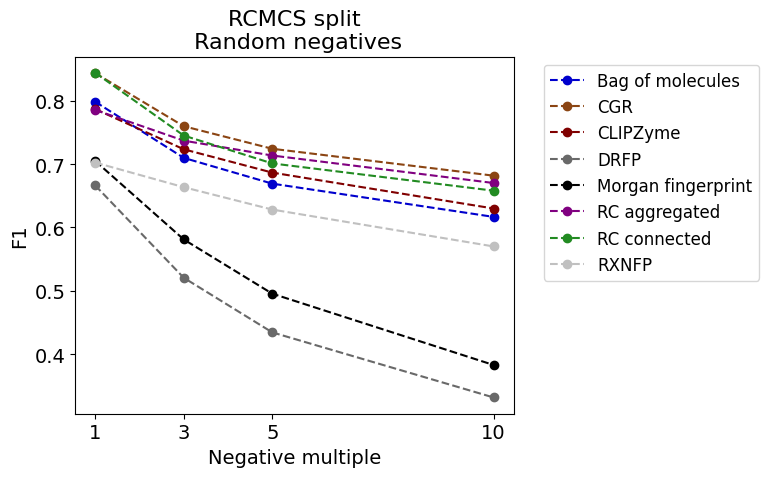

No f1 rows for homology, skipping.


In [20]:

# Line plots: F1 vs negative multiple for selected split strategies

strategies = ["rcmcs", "random_reaction", "random_reaction_center", "homology"]

for strat in strategies:
    df = metrics_table[(metrics_table['data'] == strat) & (metrics_table['metric'] == 'f1')]
    if df.empty:
        print(f"No f1 rows for {strat}, skipping.")
        continue

    pivot = df.pivot_table(index='neg_multiple', columns='model', values='mean')
    neg_mults = sorted(pivot.index.tolist())

    fig, ax = plt.subplots(figsize=(8, 5))
    for model in pivot.columns:
        y = pivot[model].reindex(neg_mults).values
        col = colors.get(model, 'gray')
        ax.plot(neg_mults, y, marker='o', linestyle='--', color=col, label=labels.get(model, model))

    ax.set_xlabel("Negative multiple")
    ax.set_ylabel("F1")
    ax.set_title(f"{similarity_names.get(strat, strat)} split\n {'Random' if strat in ['rcmcs', 'homology'] else 'Alternate reaction center'} negatives")
    ax.set_xticks(neg_mults)
    ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.tight_layout()
    plt.savefig(save_to.parent / "methods" / f"{strat}_f1_vs_neg_multiple.svg")
    plt.show()

In [21]:
metrics_table.to_csv(Path(filepaths.artifacts) / "evaluation_metrics.csv", sep=',', index=False)
split_metrics_table.to_csv(Path(filepaths.artifacts) / "evaluation_metrics_by_similarity_split.csv", sep=',', index=False)

In [22]:
from collections import defaultdict

# Check if indices are identical for each (data, neg_multiple) combo across models

# Group indices by (data, neg_multiple)
combo_indices = defaultdict(list)
for id, nm_dict in nm_keep_indices.items():
    data = id2name[id]['data']
    for nm, idxs in nm_dict.items():
        combo_indices[(data, nm)].append((id, idxs))

# Report mismatches
for combo, id_idx_list in combo_indices.items():
    # Use the first set of indices as reference
    ref_idxs = id_idx_list[0][1]
    for id, idxs in id_idx_list[1:]:
        if not np.array_equal(ref_idxs, idxs):
            print(f"Mismatch for {combo} between models: {id_idx_list[0][0]} and {id}")
        else:
            print(f"Indices match for {combo} between models: {id_idx_list[0][0]} and {id}")

Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and c4fdab61494a4affb7b48b3f18b0a314
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 120f090f4b3e471a965979401b3271ae
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 7e836b6654ac4b9aba81fe692b059c5d
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 55c062d229394c4f82828814300c0f2b
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 56c0235555af4e4c98dd6293c824cc2f
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 1d6c62f5f2d44b3fa82851639fb44ead
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold
Indices match for ('random_reaction', 3) between models: 000fc5f378954a27bf934ccd5824